In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('../../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from datasets.datasethandler import DatasetHandler
datasetHandler = DatasetHandler()

In [19]:
import torch
import pytorch_lightning as pl
import pytorch_lightning.loggers as loggers
import optuna
from optuna.integration import PyTorchLightningPruningCallback

from classification.models.M5 import M5PLModule
from classification.trainer.HyperParamSearch import MetricsCallback, save_model

* entweder: nach JEDER epoch "robustness-criterion" berechnen -> dauert ewig, dann z.B. nur 1-2 Werte pro Attack
* oder nur nach 10 epochs. dann aber kein pruning.

Ersmtal: mit Pruning.

In [4]:
from attacks.pgd import ProjectedGradientDescent
from utils.RobustnessExperiment import load_module

model = load_module("/nfs/students/summer-term-2020/project-4/SAVED_MODELS/M5/M5_attack_ProjectedGradientDescent_v69_epoch_10.p", M5PLModule)
datasetHandler.load(model, 'training')
datasetHandler.load(model, 'validation')

def special_validation_end(model, loader):
    model.eval()
    print("special validation end")
    attack = ProjectedGradientDescent(model, loader, {"norm":"inf", "epsilon": .1}, early_stopping=-1, device='cuda', save_samples=True)
    attack.attack()
    report_inf = attack.report( log = False )

    attack = ProjectedGradientDescent(model, loader, {"norm":"1", "epsilon": 5000}, early_stopping=-1, device='cuda', save_samples=True)
    attack.attack()
    report_l1 = attack.report( log = False )

    special_logs = {"score_inf": report_inf["acc"], "score_l1": report_l1["acc"]}
    return special_logs

#special_validation_end(model.model, model.val_dataloader())

/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


# Objective

In [24]:
from attacks.pgd import ProjectedGradientDescent
import config
from utils.RobustnessExperiment import load_experiment
experiment = load_experiment(exp_folder = "0007_QUICK_EVALUATION")

ID = "1"

def objective(trial):
    metrics_callback = MetricsCallback()  
    
    # create a trainer
    trainer = pl.Trainer(
        logger = loggers.TensorBoardLogger(config.LOG_DIR, name="Adv_Optimization"),
        max_epochs=20,                                                               
        gpus=1 if torch.cuda.is_available() else None,
        callbacks=[metrics_callback]                                                  # save latest accuracy
      #  early_stop_callback=PyTorchLightningPruningCallback(trial, monitor="validation_acc"), # early stopping
    )
    
    #trial.logger_version = trainer.logger.version

    # here we sample the hyper params, similar as in our old random search
    trial_hparams = {"batch_size": trial.suggest_categorical('batch_size', [64]),
                     "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-1),
                     "p_drop": trial.suggest_float("p_drop", 0, 0.5),
                     "lr_decay": trial.suggest_float("lr_decay", 0.8, 1),
                     "weight_decay": trial.suggest_float("weight_decay", 1e-6, 1e-1)
                    }
    
    trial_current_attack = ProjectedGradientDescent
    trial_attack_args = {"norm":"2", 
                                   "epsilon":
                         
                                      {"SAMPLING_MODE": "log_batch", 
                                       "l": 1, 
                                       "u": trial.suggest_loguniform("eps_up", 1, 150)},
                                 }
    
    trial_hparams["attack_args_backup"] = trial_attack_args

    model = M5PLModule(trial_hparams)
    datasetHandler.load(model, 'training')
    datasetHandler.load(model, 'validation')   
    model.setAttack(trial_current_attack, trial_attack_args)
    #model.set_special_validation_end(special_validation_end)


    # train model
    trainer.fit(model)
    
    # save model
    model_path = os.path.join("saved_models", 'run{}_v{}.p'.format(ID, trial.number))
    model.save(model_path)

    # run adv attacks
    experiment.run(model_path, M5PLModule)
    performance = experiment.get_model_performance(model_path)
    print("Robustness-Performance: ", performance)

    #return metrics_callback.metrics[-1]["validation_acc"]
    return performance

Loaded model 0007_QUICK_EVALUATION



Attack = FGSM:
[(0.3897550111358574, 'M5_attack_ProjectedGradientDescent_v69_epoch_40.p')]

Attack = FGA L2:
[(0.49368968077208614, 'M5_attack_ProjectedGradientDescent_v69_epoch_40.p')]

Attack = FGA L1:
[(0.4127691165553081, 'M5_attack_ProjectedGradientDescent_v69_epoch_40.p')]


# Run Search

GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

   | Name           | Type         | Params
--------------------------------------------
0  | model          | M5           | 555 K 
1  | model.model    | Sequential   | 555 K 
2  | model.model.0  | Conv1d       | 10 K  
3  | model.model.1  | BatchNorm1d  | 256   
4  | model.model.2  | MaxPool1d    | 0     
5  | model.model.3  | Dropout      | 0     
6  | model.model.4  | Conv1d       | 49 K  
7  | model.model.5  | BatchNorm1d  | 256   
8  | model.model.6  | MaxPool1d    | 0     
9  | model.model.7  | Dropout      | 0     
10 | model.model.8  | Conv1d       | 98 K  
11 | model.model.9  | BatchNorm1d  | 512   
12 | model.model.10 | MaxPool1d    | 0     
13 | model.model.11 | Dropout      | 0     
14 | model.model.12 | Co

Val-Acc=0.033787788974510964


Val-Acc=0.7255483106105513


Val-Acc=0.8002371072910492


Val-Acc=0.7581505631298162


Val-Acc=0.5868405453467694


Val-Acc=0.7213989330171903


Val-Acc=0.5589804386484885


Val-Acc=0.7800829875518672


Val-Acc=0.6342620035566093


Val-Acc=0.7913455838767042


Val-Acc=0.7599288678126852


Val-Acc=0.5577949021932425


Val-Acc=0.7889745109662122


Val-Acc=0.7095435684647303


Val-Acc=0.7765263781861292


Val-Acc=0.7296976882039122


Val-Acc=0.7445168938944873


Val-Acc=0.7812685240071132


Val-Acc=0.8144635447540012


Val-Acc=0.8002371072910492


Val-Acc=0.7806757557794902

Saved model to "saved_models/run1_v0.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


Running experiment on model run1_v0.p

Perform Attack #1/3: FGSM
Attack FGSM has already been performed for model run1_v0.p - skipping.

Perform Attack #2/3: FGA L2
Attack FGA L2 has already been performed for model run1_v0.p - skipping.

Perform Attack #3/3: FGA L1
Attack FGA L1 has already been performed for model run1_v0.p - skipping.
Robustness-Performance:  2.2726733847065796


[I 2020-06-21 13:30:37,809] Finished trial#0 with value: 2.2726733847065796 with parameters: {'batch_size': 64, 'learning_rate': 0.07904100361972893, 'p_drop': 0.47718350541271726, 'lr_decay': 0.8681630924533227, 'weight_decay': 0.050432586147292846, 'eps_up': 25.78093535535097}. Best is trial#0 with value: 2.2726733847065796.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

   | Name           | Type         | Params
--------------------------------------------
0  | model          | M5           | 555 K 
1  | model.model    | Sequential   | 555 K 
2  | model.model.0  | Conv1d       | 10 K  
3  | model.model.1  | BatchNorm1d  | 256   
4  | model.model.2  | MaxPool1d    | 0     
5  | model.model.3  | Dropout      | 0     
6  | model.model.4  | Conv1d       | 49 K  
7  

Val-Acc=0.03793716656787196


Val-Acc=0.7451096621221103


Val-Acc=0.7492590397154713


Val-Acc=0.7225844694724363


Val-Acc=0.7261410788381742


Val-Acc=0.7842323651452282


Val-Acc=0.7036158861885004


Val-Acc=0.8079430942501482


Val-Acc=0.6455245998814464


Val-Acc=0.7255483106105513


Val-Acc=0.7883817427385892


Val-Acc=0.7729697688203913


Val-Acc=0.6686425607587433


Val-Acc=0.6858328393598103


Val-Acc=0.6905749851807943


Val-Acc=0.6947243627741553


Val-Acc=0.6514522821576764


Val-Acc=0.7285121517486662


Val-Acc=0.7575577949021932


Val-Acc=0.7213989330171903


Val-Acc=0.6455245998814464

Saved model to "saved_models/run1_v1.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/2 [00:00<?, ?it/s]



Running experiment on model run1_v1.p
Created Dir '/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/run1_v1.p'

Perform Attack #1/3: FGSM


100%|██████████| 2/2 [00:07<00:00,  3.97s/it]


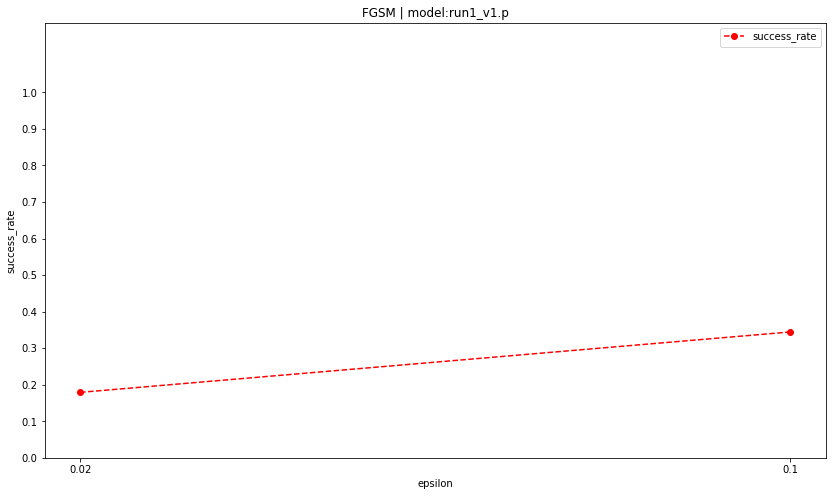

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #2/3: FGA L2


100%|██████████| 2/2 [00:07<00:00,  3.86s/it]


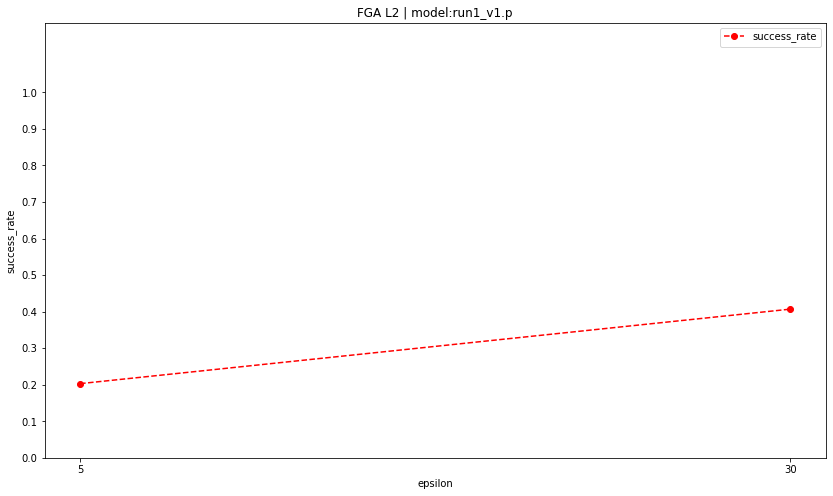

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #3/3: FGA L1


100%|██████████| 2/2 [00:07<00:00,  3.85s/it]


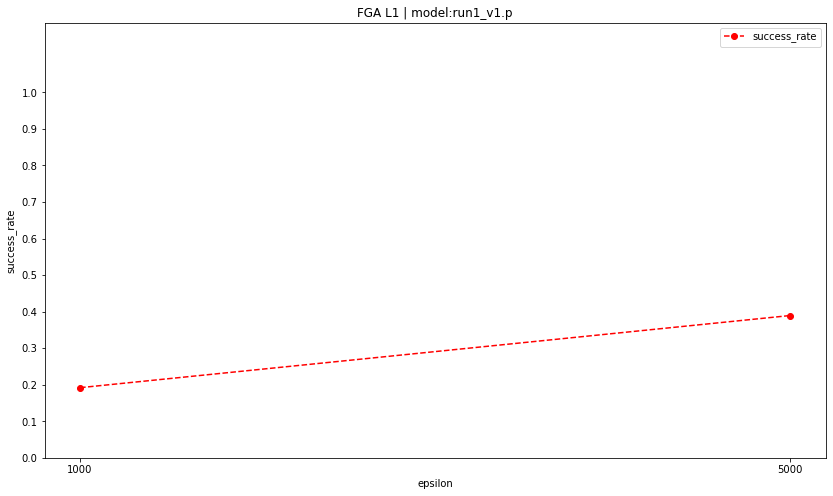

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"
Robustness-Performance:  2.766449318316538


[I 2020-06-21 13:38:07,578] Finished trial#1 with value: 2.766449318316538 with parameters: {'batch_size': 64, 'learning_rate': 0.0001076813781392008, 'p_drop': 0.11651581328199734, 'lr_decay': 0.8964223395661051, 'weight_decay': 0.08474915457017411, 'eps_up': 5.6889271683098475}. Best is trial#1 with value: 2.766449318316538.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

   | Name           | Type         | Params
-----------------------------------

Val-Acc=0.02133965619442798


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.7474807350326023


Val-Acc=0.6911677534084173


Val-Acc=0.7860106698280972


Val-Acc=0.6484884410195614


Val-Acc=0.7427385892116183


Val-Acc=0.7320687611144042


Val-Acc=0.7178423236514523


Val-Acc=0.7350326022525193


Val-Acc=0.6111440426793124


Val-Acc=0.6295198577356254


Val-Acc=0.7231772377000593


Val-Acc=0.7213989330171903


Val-Acc=0.6058091286307054


Val-Acc=0.6484884410195614


Val-Acc=0.6621221102548903


Val-Acc=0.7646710136336692


Val-Acc=0.6532305868405454


Val-Acc=0.6443390634262004


Val-Acc=0.7125074096028453


Val-Acc=0.6573799644339063

Saved model to "saved_models/run1_v2.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/2 [00:00<?, ?it/s]



Running experiment on model run1_v2.p
Created Dir '/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/run1_v2.p'

Perform Attack #1/3: FGSM


100%|██████████| 2/2 [00:07<00:00,  3.99s/it]


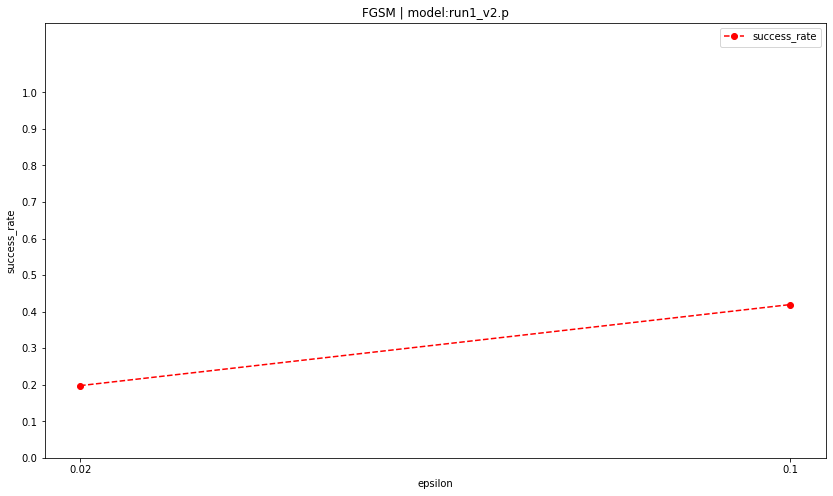

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #2/3: FGA L2


100%|██████████| 2/2 [00:07<00:00,  3.92s/it]


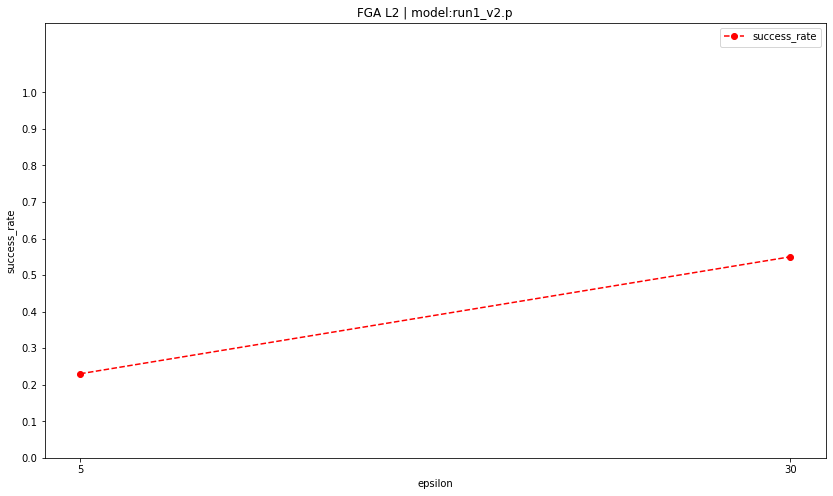

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #3/3: FGA L1


100%|██████████| 2/2 [00:07<00:00,  3.91s/it]


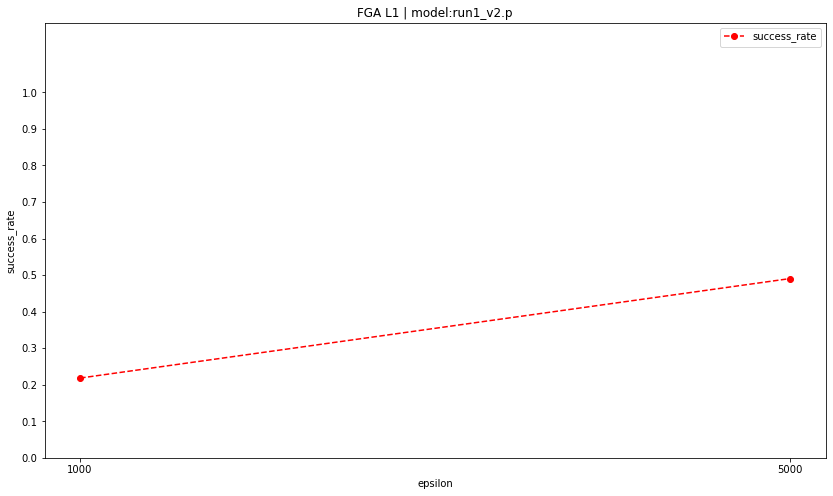

[I 2020-06-21 13:45:43,798] Finished trial#2 with value: 2.5601659751037342 with parameters: {'batch_size': 64, 'learning_rate': 7.321184681004391e-05, 'p_drop': 0.11437968445909558, 'lr_decay': 0.9676063331458026, 'weight_decay': 0.03221337563592092, 'eps_up': 2.8900557391960375}. Best is trial#1 with value: 2.766449318316538.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]


Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"
Robustness-Performance:  2.5601659751037342


INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

   | Name           | Type         | Params
--------------------------------------------
0  | model          | M5           | 555 K 
1  | model.model    | Sequential   | 555 K 
2  | model.model.0  | Conv1d       | 10 K  
3  | model.model.1  | BatchNorm1d  | 256   
4  | model.model.2  | MaxPool1d    | 0     
5  | model.model.3  | Dropout      | 0     
6  | model.model.4  | Conv1d       | 49 K  
7  | model.model.5  | BatchNorm1d  | 256   
8  | model.model.6  | MaxPool1d    | 0     
9  | model.model.7  | Dropout      | 0     
10 | model.model.8  | Conv1d       | 98 K

Val-Acc=0.03793716656787196


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.6342620035566093


Val-Acc=0.7095435684647303


Val-Acc=0.6674570243034973


Val-Acc=0.6176644931831654


Val-Acc=0.7397747480735033


Val-Acc=0.7848251333728512


Val-Acc=0.7889745109662122


Val-Acc=0.7860106698280972


Val-Acc=0.7652637818612922


Val-Acc=0.8049792531120332


Val-Acc=0.7605216360403082


Val-Acc=0.7131001778304683


Val-Acc=0.7326615293420272


Val-Acc=0.8026081802015412


Val-Acc=0.8269116775340841


Val-Acc=0.6953171310017783


Val-Acc=0.7415530527563723


Val-Acc=0.7142857142857143


Val-Acc=0.7913455838767042


Val-Acc=0.8174273858921162

Saved model to "saved_models/run1_v3.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/2 [00:00<?, ?it/s]



Running experiment on model run1_v3.p
Created Dir '/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/run1_v3.p'

Perform Attack #1/3: FGSM


100%|██████████| 2/2 [00:09<00:00,  4.59s/it]


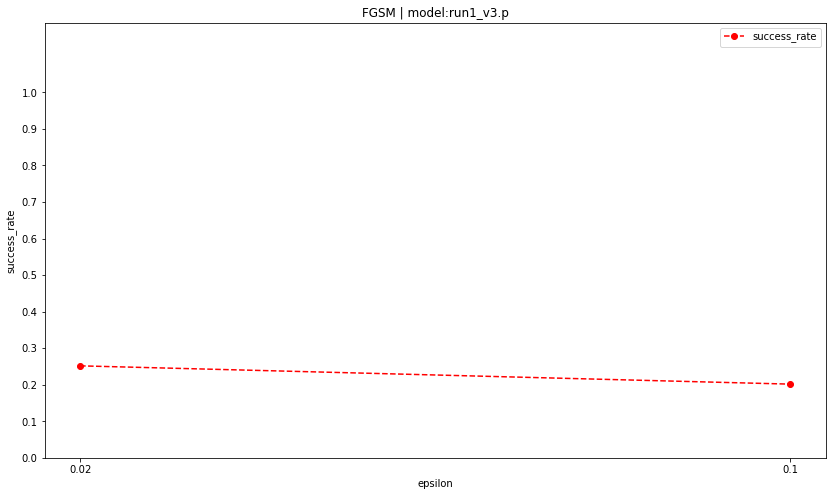

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #2/3: FGA L2


100%|██████████| 2/2 [00:09<00:00,  4.51s/it]


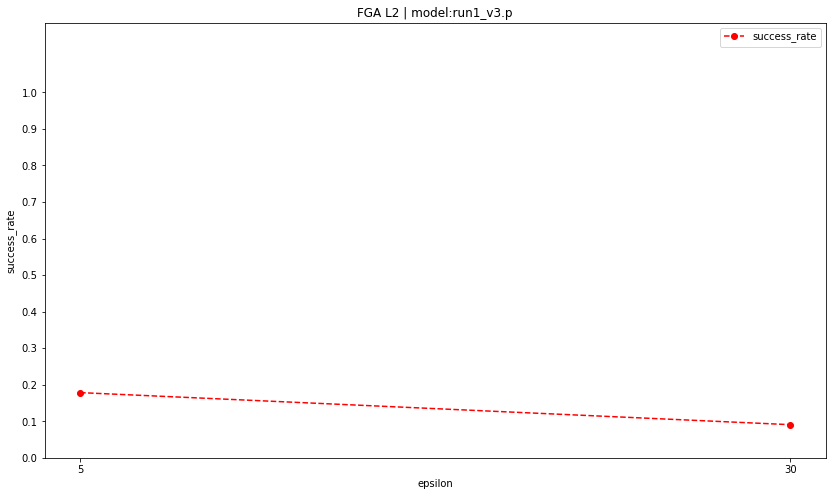

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #3/3: FGA L1


100%|██████████| 2/2 [00:09<00:00,  4.50s/it]


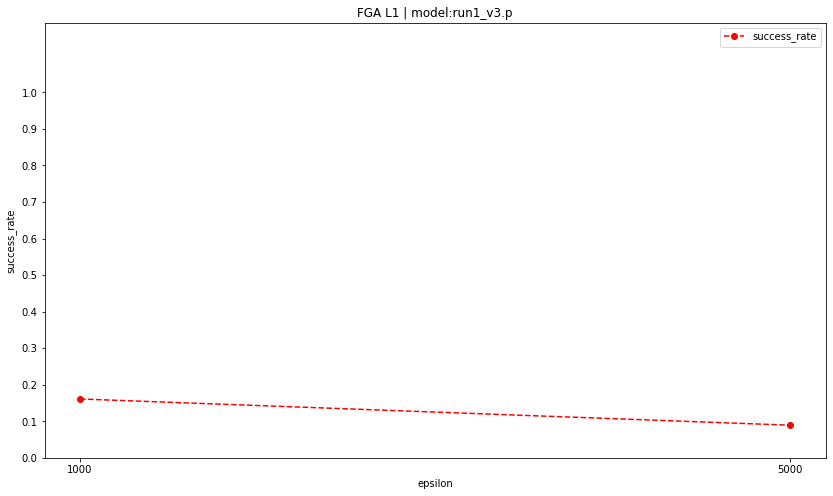

[I 2020-06-21 13:53:24,738] Finished trial#3 with value: 4.1096621221102545 with parameters: {'batch_size': 64, 'learning_rate': 0.04291052530762145, 'p_drop': 0.31921502596995555, 'lr_decay': 0.8148433074588798, 'weight_decay': 0.05915579933982264, 'eps_up': 1.887757719201873}. Best is trial#3 with value: 4.1096621221102545.
GPU available: True, used: True


Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"
Robustness-Performance:  4.1096621221102545


INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

   | Name           | Type         | Params
--------------------------------------------
0  | model          | M5           | 555 K 
1  | model.model    | Sequential   | 555 K 
2  | model.model.0  | Conv1d       | 10 K  
3  | model.model.1  | BatchNorm1d  | 256   
4  | model.model.2  | MaxPool1d    | 0     
5  | model.model.3  | Dropout      | 0     
6  | model.model.4  | Conv1d       | 49 K  
7  | model.model.5  | BatchNorm1d  | 256   

Val-Acc=0.036751630112625965


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.7403675163011263


Val-Acc=0.6840545346769413


Val-Acc=0.6668642560758743


Val-Acc=0.5880260818020154


Val-Acc=0.6597510373443983


Val-Acc=0.7302904564315352


Val-Acc=0.7664493183165383


Val-Acc=0.5898043864848844


Val-Acc=0.7391819798458803


Val-Acc=0.5044457617071725


Val-Acc=0.5293420272673385


Val-Acc=0.4943687018375815


Val-Acc=0.6366330764671013


Val-Acc=0.6437462951985774


Val-Acc=0.6271487848251334


Val-Acc=0.5257854179016005


Val-Acc=0.5832839359810315


Val-Acc=0.5257854179016005


Val-Acc=0.5328986366330765


Val-Acc=0.49259039715471253

Saved model to "saved_models/run1_v4.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/2 [00:00<?, ?it/s]



Running experiment on model run1_v4.p
Created Dir '/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/run1_v4.p'

Perform Attack #1/3: FGSM


100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


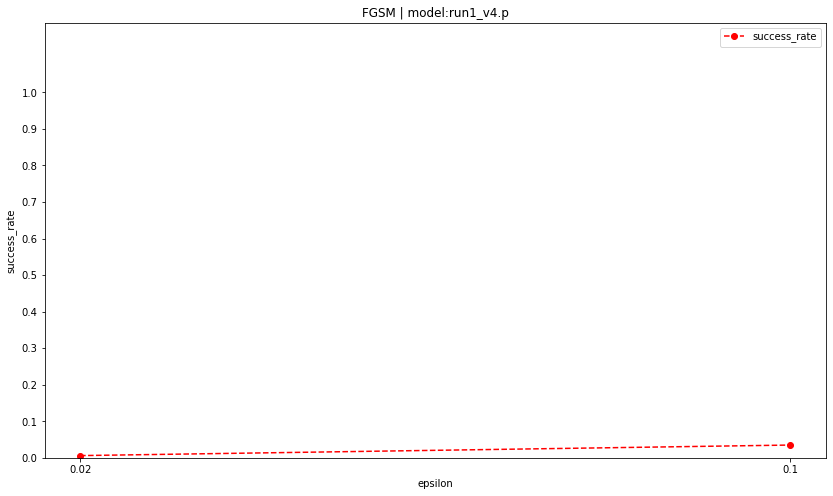

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #2/3: FGA L2


100%|██████████| 2/2 [00:06<00:00,  3.31s/it]


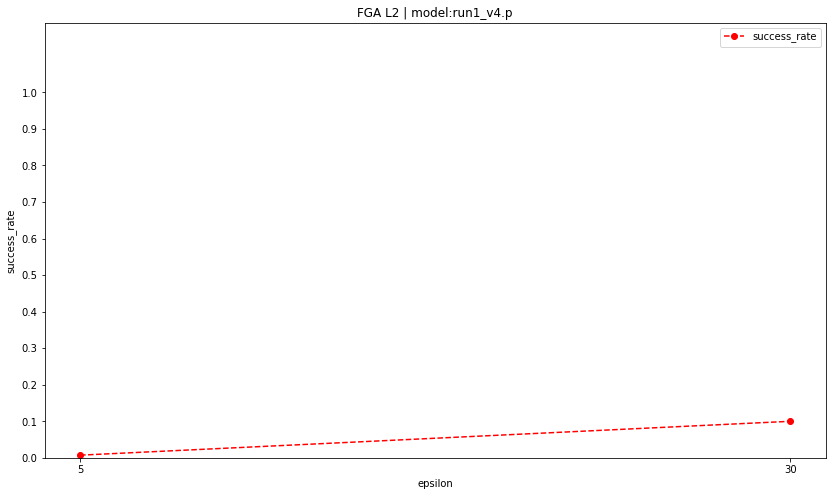

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #3/3: FGA L1


100%|██████████| 2/2 [00:06<00:00,  3.31s/it]


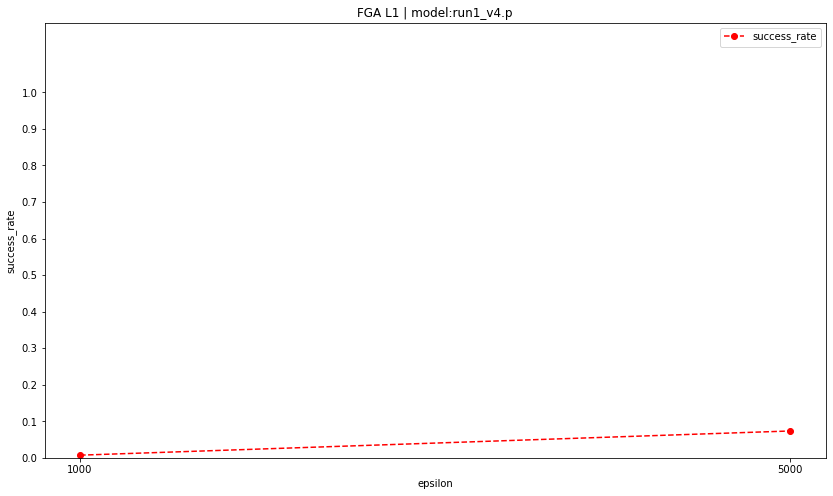

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"
Robustness-Performance:  2.842916419679905


[I 2020-06-21 14:00:56,545] Finished trial#4 with value: 2.842916419679905 with parameters: {'batch_size': 64, 'learning_rate': 0.0006056282635275487, 'p_drop': 0.3392441543612717, 'lr_decay': 0.8512903047517724, 'weight_decay': 0.025651437388064982, 'eps_up': 1.1281524181252458}. Best is trial#3 with value: 4.1096621221102545.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

   | Name           | Type         | Params
----------------------------------

Val-Acc=0.03852993479549496


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.7415530527563723


Val-Acc=0.7599288678126852


Val-Acc=0.7291049199762892


Val-Acc=0.7492590397154713


Val-Acc=0.7012448132780082


Val-Acc=0.7285121517486662


Val-Acc=0.7729697688203913


Val-Acc=0.7800829875518672


Val-Acc=0.6650859513930053


Val-Acc=0.7344398340248963


Val-Acc=0.7913455838767042


Val-Acc=0.7860106698280972


Val-Acc=0.7996443390634262


Val-Acc=0.8043864848844102


Val-Acc=0.7000592768227623


Val-Acc=0.8085358624777712


Val-Acc=0.8162418494368702


Val-Acc=0.5903971547125074


Val-Acc=0.6899822169531713


Val-Acc=0.7806757557794902

Saved model to "saved_models/run1_v5.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/2 [00:00<?, ?it/s]



Running experiment on model run1_v5.p
Created Dir '/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/run1_v5.p'

Perform Attack #1/3: FGSM


100%|██████████| 2/2 [00:08<00:00,  4.42s/it]


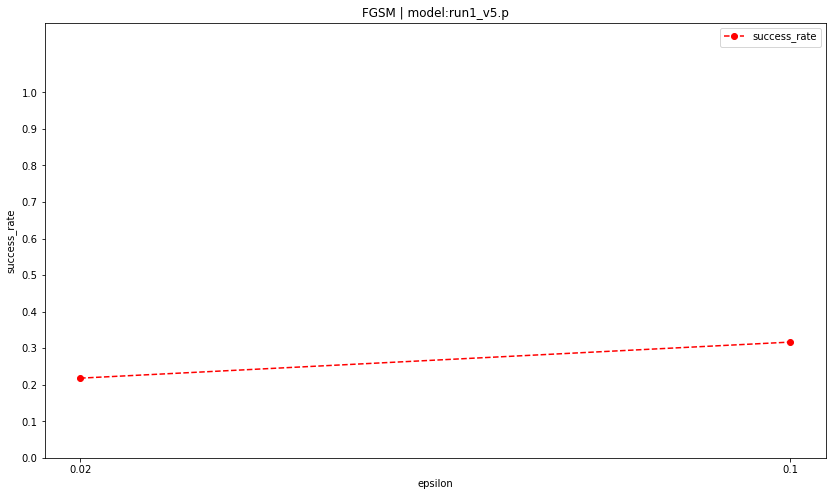

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #2/3: FGA L2


100%|██████████| 2/2 [00:08<00:00,  4.35s/it]


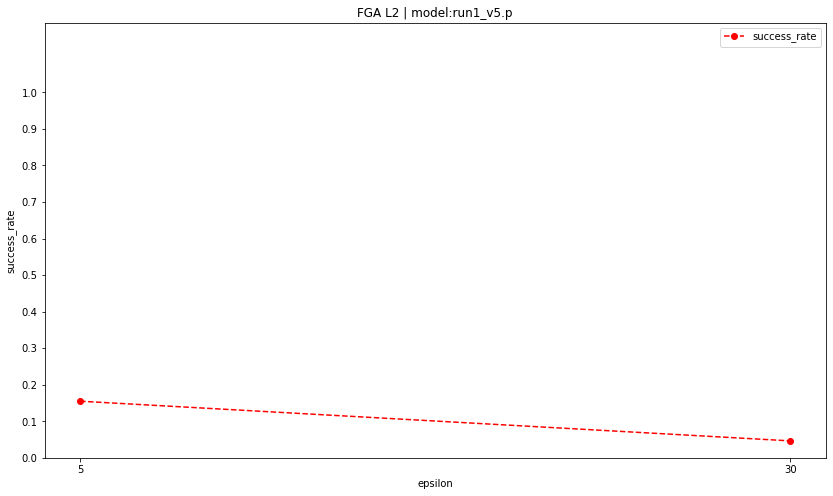

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #3/3: FGA L1


100%|██████████| 2/2 [00:08<00:00,  4.35s/it]


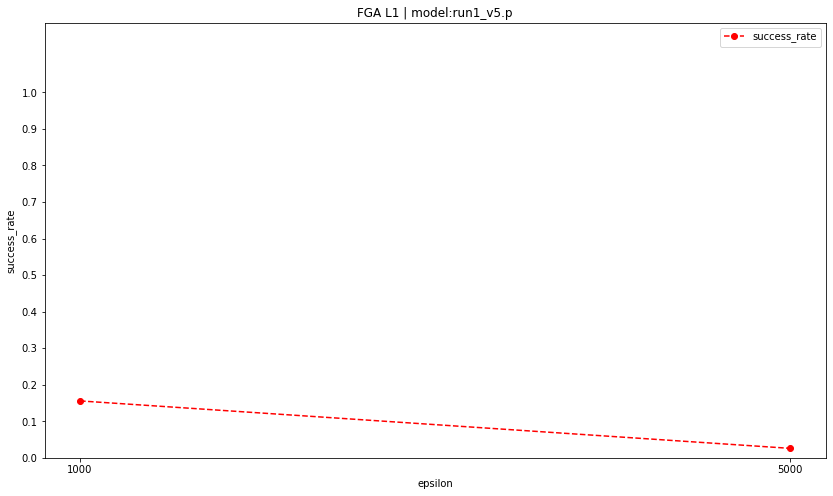

[I 2020-06-21 14:08:33,039] Finished trial#5 with value: 3.9679905157083577 with parameters: {'batch_size': 64, 'learning_rate': 0.015220347021146685, 'p_drop': 0.3041508530953594, 'lr_decay': 0.9707800548605134, 'weight_decay': 0.04544583500168255, 'eps_up': 113.93549046483851}. Best is trial#3 with value: 4.1096621221102545.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]


Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"
Robustness-Performance:  3.9679905157083577


INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

   | Name           | Type         | Params
--------------------------------------------
0  | model          | M5           | 555 K 
1  | model.model    | Sequential   | 555 K 
2  | model.model.0  | Conv1d       | 10 K  
3  | model.model.1  | BatchNorm1d  | 256   
4  | model.model.2  | MaxPool1d    | 0     
5  | model.model.3  | Dropout      | 0     
6  | model.model.4  | Conv1d       | 49 K  
7  | model.model.5  | BatchNorm1d  | 256   
8  | model.model.6  | MaxPool1d    | 0     
9  | model.model.7  | Dropout      | 0     
10 | model.model.8  | Conv1d       | 98 K

Val-Acc=0.03852993479549496


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.5477178423236515


Val-Acc=0.7871962062833432


Val-Acc=0.7024303497332542


Val-Acc=0.7895672791938352


Val-Acc=0.7457024303497333


Val-Acc=0.7765263781861292


Val-Acc=0.7949021932424422


Val-Acc=0.7972732661529343


Val-Acc=0.8037937166567872


Val-Acc=0.6312981624184943


Val-Acc=0.7937166567871962


Val-Acc=0.7540011855364552


Val-Acc=0.7682276229994073


Val-Acc=0.8156490812092472


Val-Acc=0.8138707765263782


Val-Acc=0.8049792531120332


Val-Acc=0.8097213989330172


Val-Acc=0.8049792531120332


Val-Acc=0.7445168938944873


Val-Acc=0.7474807350326023

Saved model to "saved_models/run1_v6.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/2 [00:00<?, ?it/s]



Running experiment on model run1_v6.p
Created Dir '/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/run1_v6.p'

Perform Attack #1/3: FGSM


100%|██████████| 2/2 [00:08<00:00,  4.33s/it]


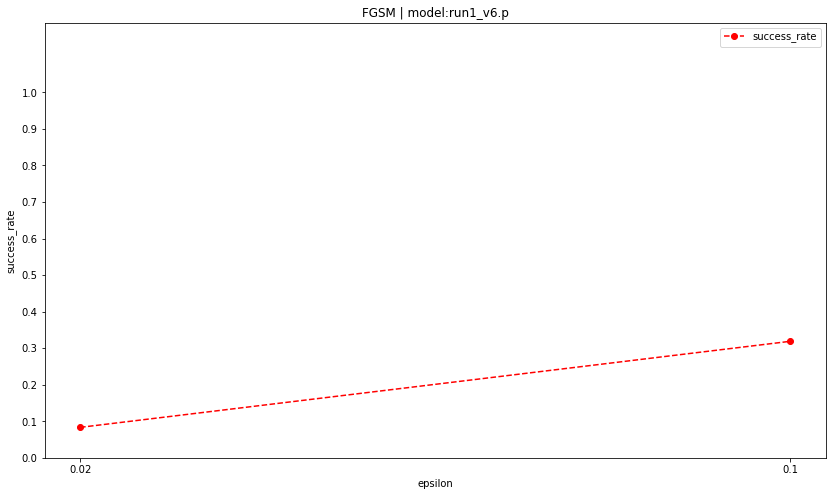

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #2/3: FGA L2


100%|██████████| 2/2 [00:08<00:00,  4.32s/it]


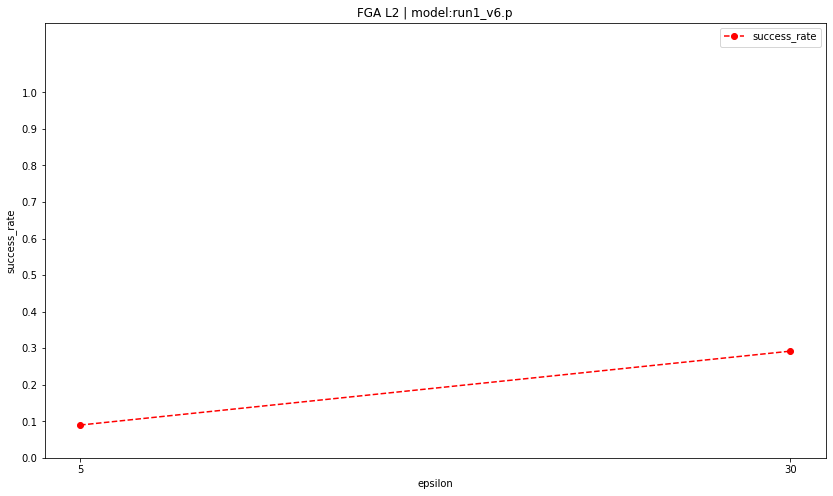

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #3/3: FGA L1


100%|██████████| 2/2 [00:08<00:00,  4.33s/it]


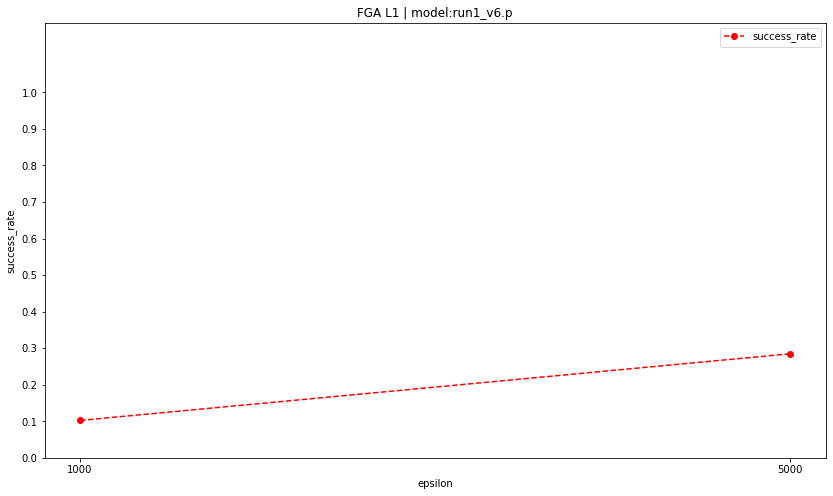

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"
Robustness-Performance:  3.609958506224067


[I 2020-06-21 14:16:11,286] Finished trial#6 with value: 3.609958506224067 with parameters: {'batch_size': 64, 'learning_rate': 0.01776662725360953, 'p_drop': 0.11037098650104238, 'lr_decay': 0.8477870331013451, 'weight_decay': 0.0980053638990139, 'eps_up': 28.580238346816866}. Best is trial#3 with value: 4.1096621221102545.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

   | Name           | Type         | Params
-------------------------------------

Val-Acc=0.03793716656787196


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.7516301126259632


Val-Acc=0.7705986959098993


Val-Acc=0.7291049199762892


Val-Acc=0.5471250740960285


Val-Acc=0.6384113811499703


Val-Acc=0.7190278601066983


Val-Acc=0.7688203912270303


Val-Acc=0.6698280972139893


Val-Acc=0.7285121517486662


Val-Acc=0.7285121517486662


Val-Acc=0.6514522821576764


Val-Acc=0.7267338470657972


Val-Acc=0.5957320687611144


Val-Acc=0.6710136336692353


Val-Acc=0.6716064018968583


Val-Acc=0.6692353289863663


Val-Acc=0.8132780082987552


Val-Acc=0.7646710136336692


Val-Acc=0.7243627741553053


Val-Acc=0.6295198577356254

Saved model to "saved_models/run1_v7.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/2 [00:00<?, ?it/s]



Running experiment on model run1_v7.p
Created Dir '/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/run1_v7.p'

Perform Attack #1/3: FGSM


100%|██████████| 2/2 [00:07<00:00,  3.89s/it]


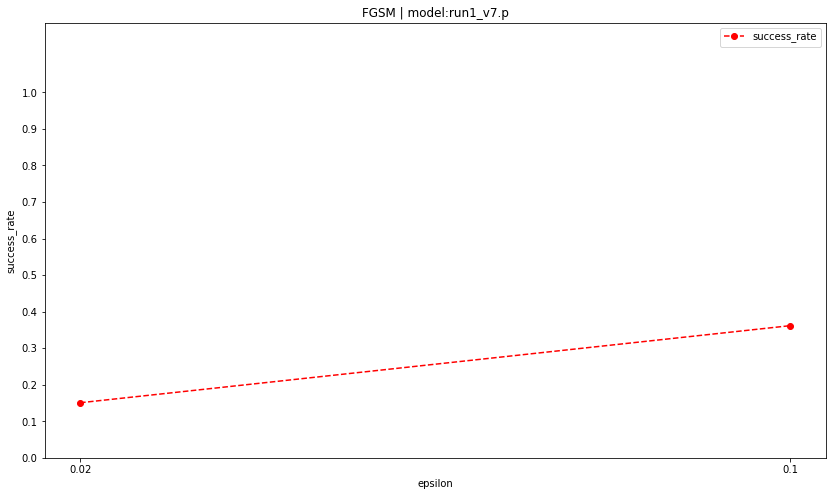

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #2/3: FGA L2


100%|██████████| 2/2 [00:07<00:00,  3.79s/it]


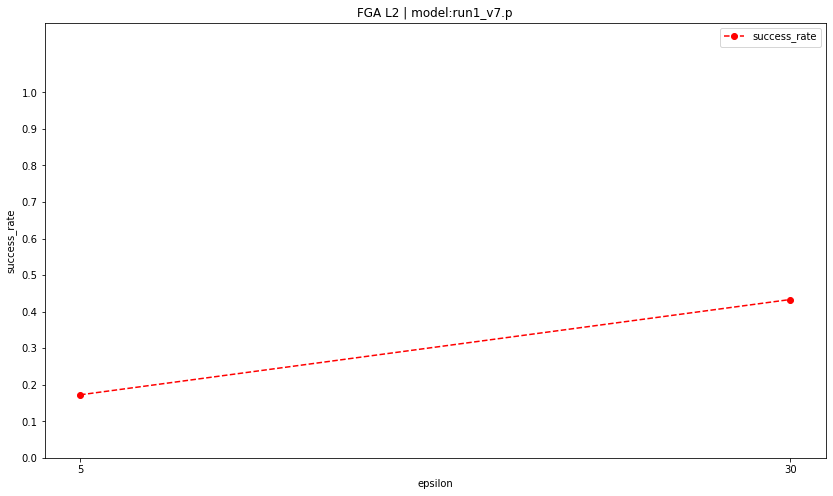

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #3/3: FGA L1


100%|██████████| 2/2 [00:07<00:00,  3.80s/it]


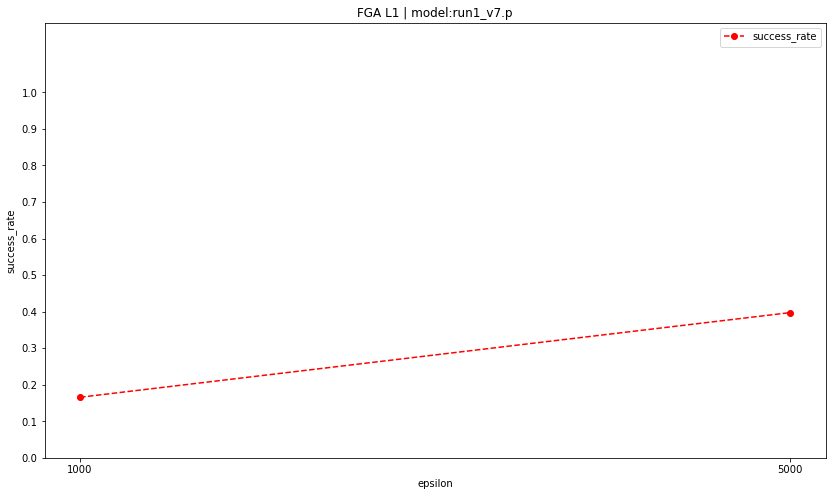

[I 2020-06-21 14:23:48,643] Finished trial#7 with value: 2.7190278601066984 with parameters: {'batch_size': 64, 'learning_rate': 0.000406609580705237, 'p_drop': 0.1770847590637294, 'lr_decay': 0.9468893662966386, 'weight_decay': 0.012191015024927605, 'eps_up': 2.449223702181414}. Best is trial#3 with value: 4.1096621221102545.
GPU available: True, used: True


Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"
Robustness-Performance:  2.7190278601066984


INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

   | Name           | Type         | Params
--------------------------------------------
0  | model          | M5           | 555 K 
1  | model.model    | Sequential   | 555 K 
2  | model.model.0  | Conv1d       | 10 K  
3  | model.model.1  | BatchNorm1d  | 256   
4  | model.model.2  | MaxPool1d    | 0     
5  | model.model.3  | Dropout      | 0     
6  | model.model.4  | Conv1d       | 49 K  
7  | model.model.5  | BatchNorm1d  | 256   

Val-Acc=0.03912270302311796


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.6538233550681684


Val-Acc=0.6727919383521044


Val-Acc=0.7219917012448133


Val-Acc=0.6793123888559573


Val-Acc=0.6953171310017783


Val-Acc=0.7071724955542383


Val-Acc=0.7131001778304683


Val-Acc=0.7338470657972732


Val-Acc=0.7095435684647303


Val-Acc=0.7439241256668643


Val-Acc=0.7113218731475993


Val-Acc=0.7267338470657972


Val-Acc=0.7457024303497333


Val-Acc=0.7154712507409603


Val-Acc=0.7030231179608772


Val-Acc=0.6905749851807943


Val-Acc=0.7042086544161233


Val-Acc=0.7391819798458803


Val-Acc=0.7362181387077653


Val-Acc=0.7385892116182573

Saved model to "saved_models/run1_v8.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/2 [00:00<?, ?it/s]



Running experiment on model run1_v8.p
Created Dir '/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/run1_v8.p'

Perform Attack #1/3: FGSM


100%|██████████| 2/2 [00:09<00:00,  4.57s/it]


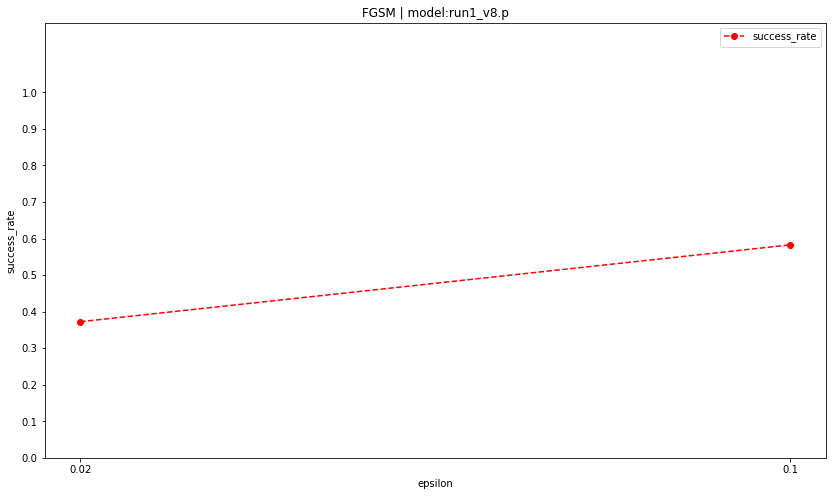

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #2/3: FGA L2


100%|██████████| 2/2 [00:12<00:00,  6.08s/it]


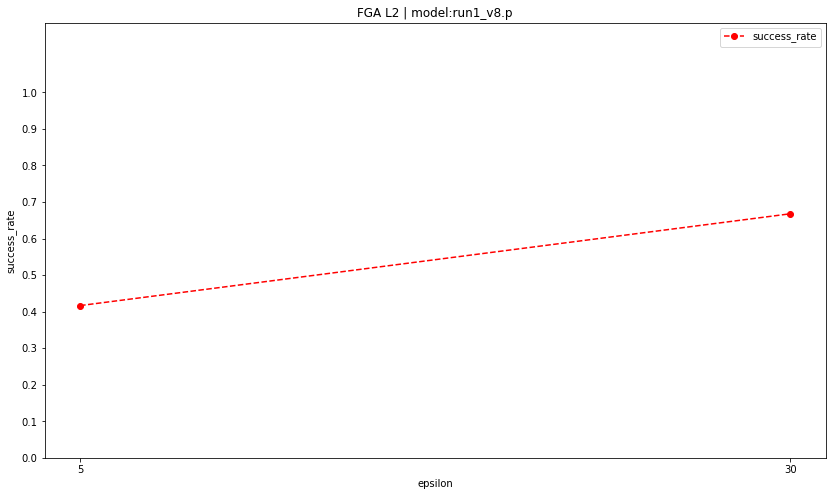

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #3/3: FGA L1


100%|██████████| 2/2 [00:11<00:00,  5.55s/it]


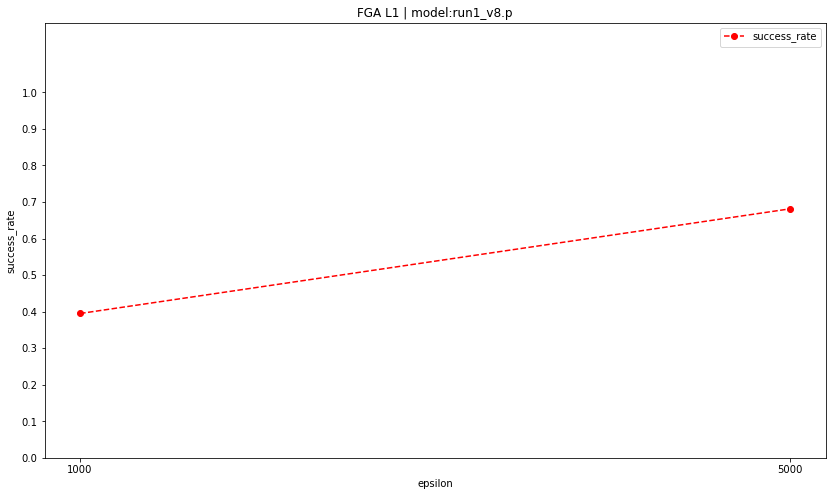

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"
Robustness-Performance:  2.1304090100770603


[I 2020-06-21 14:32:07,125] Finished trial#8 with value: 2.1304090100770603 with parameters: {'batch_size': 64, 'learning_rate': 3.02725459022168e-06, 'p_drop': 0.1864119967693364, 'lr_decay': 0.8392916588823002, 'weight_decay': 0.011512342075095787, 'eps_up': 6.907063667774881}. Best is trial#3 with value: 4.1096621221102545.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

   | Name           | Type         | Params
-----------------------------------

Val-Acc=0.03793716656787196


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.8043864848844102


Val-Acc=0.7528156490812092


Val-Acc=0.7611144042679312


Val-Acc=0.7925311203319502


Val-Acc=0.8103141671606402


Val-Acc=0.7883817427385892


Val-Acc=0.8091286307053942


Val-Acc=0.7753408417308832


Val-Acc=0.7516301126259632


Val-Acc=0.7901600474214582


Val-Acc=0.7557794902193242


Val-Acc=0.6781268524007114


Val-Acc=0.8150563129816242


Val-Acc=0.6348547717842323


Val-Acc=0.8239478363959691


Val-Acc=0.8245406046235921


Val-Acc=0.6247777119146414


Val-Acc=0.5311203319502075


Val-Acc=0.5168938944872555


Val-Acc=0.5880260818020154

Saved model to "saved_models/run1_v9.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/2 [00:00<?, ?it/s]



Running experiment on model run1_v9.p
Created Dir '/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/run1_v9.p'

Perform Attack #1/3: FGSM


100%|██████████| 2/2 [00:07<00:00,  3.80s/it]


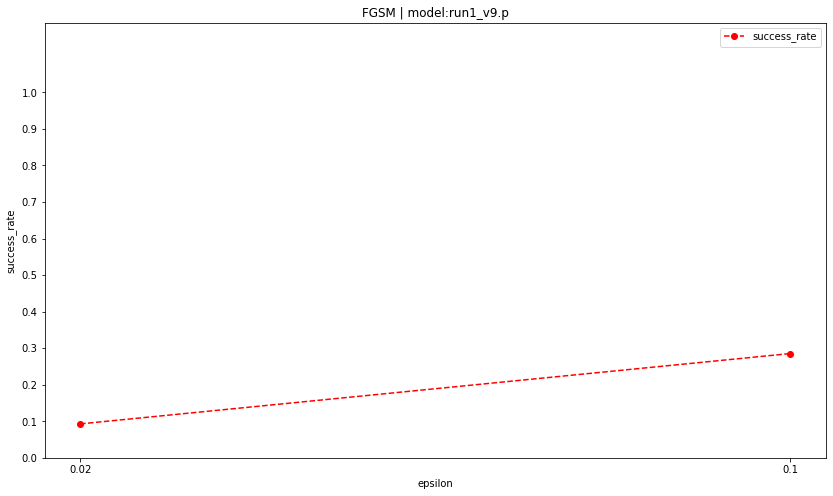

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #2/3: FGA L2


100%|██████████| 2/2 [00:07<00:00,  3.57s/it]


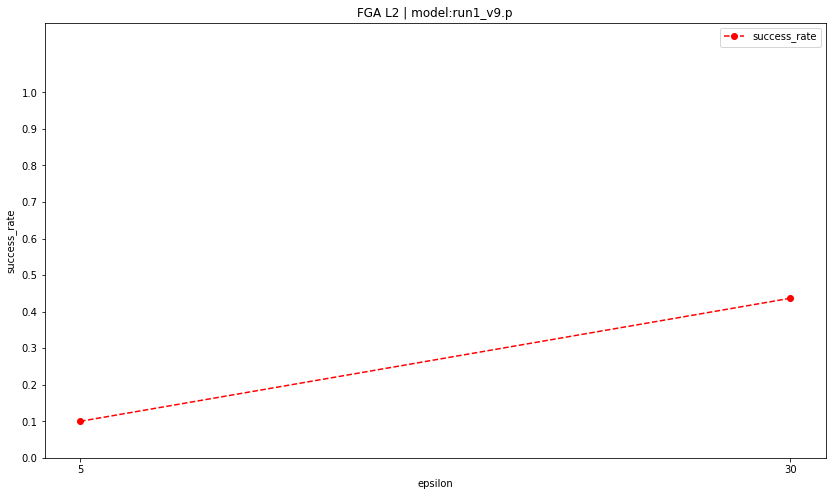

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #3/3: FGA L1


100%|██████████| 2/2 [00:07<00:00,  3.56s/it]


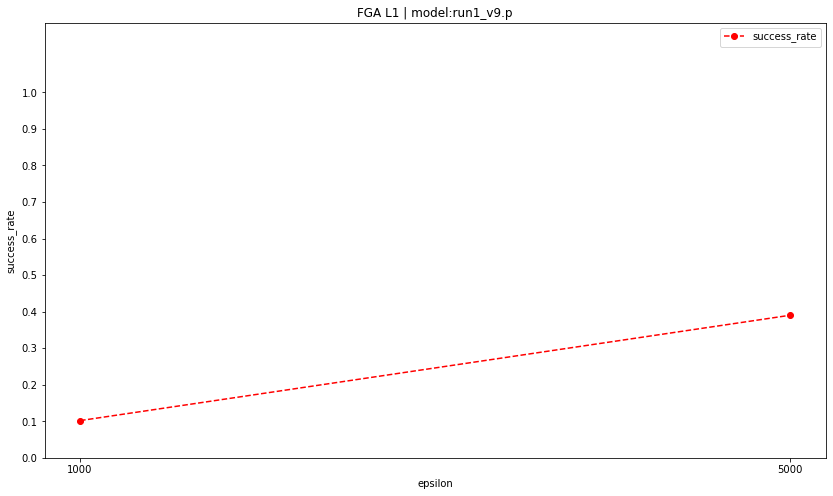

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"
Robustness-Performance:  2.7012448132780085


[I 2020-06-21 14:39:45,620] Finished trial#9 with value: 2.7012448132780085 with parameters: {'batch_size': 64, 'learning_rate': 0.005291715815253347, 'p_drop': 0.20206477817806578, 'lr_decay': 0.8545103197787013, 'weight_decay': 0.04675835791575497, 'eps_up': 8.98877862102902}. Best is trial#3 with value: 4.1096621221102545.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

   | Name           | Type         | Params
------------------------------------

Val-Acc=0.03793716656787196


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.7048014226437463


Val-Acc=0.8132780082987552


Val-Acc=0.8227622999407231


Val-Acc=0.8014226437462952


Val-Acc=0.7551867219917012


Val-Acc=0.8186129223473622


Val-Acc=0.8103141671606402


Val-Acc=0.6514522821576764


Val-Acc=0.8221695317131001


Val-Acc=0.8168346176644932


Val-Acc=0.7747480735032602


Val-Acc=0.8168346176644932


Val-Acc=0.7581505631298162


Val-Acc=0.8197984588026082


Val-Acc=0.8304682868998222


Val-Acc=0.8310610551274452


Val-Acc=0.8298755186721992


Val-Acc=0.8310610551274452


Val-Acc=0.8316538233550682


Val-Acc=0.7919383521043272

Saved model to "saved_models/run1_v10.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/2 [00:00<?, ?it/s]



Running experiment on model run1_v10.p
Created Dir '/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/run1_v10.p'

Perform Attack #1/3: FGSM


100%|██████████| 2/2 [00:08<00:00,  4.50s/it]


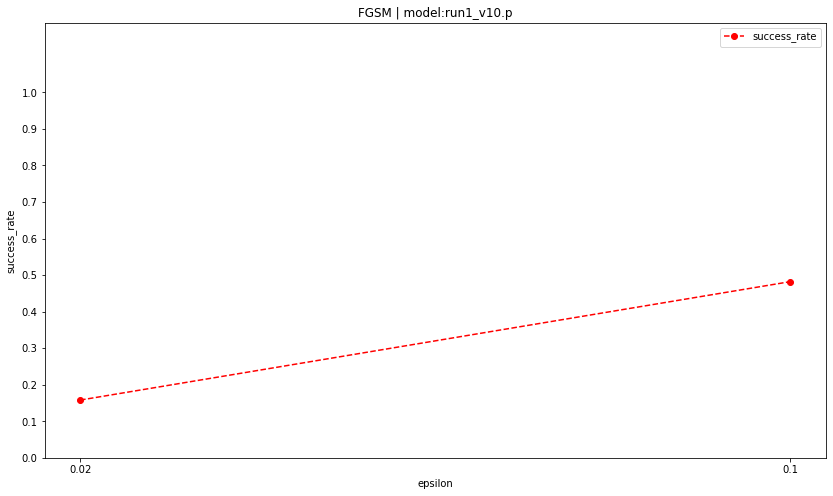

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #2/3: FGA L2


100%|██████████| 2/2 [00:08<00:00,  4.42s/it]


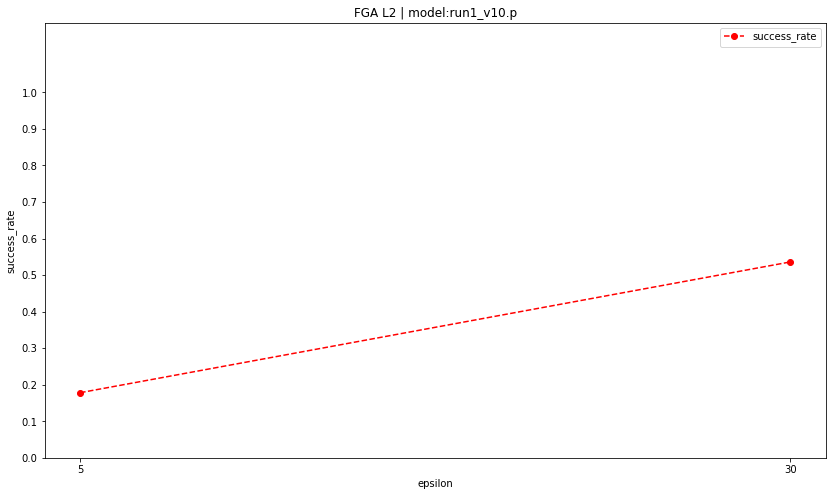

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #3/3: FGA L1


100%|██████████| 2/2 [00:08<00:00,  4.43s/it]


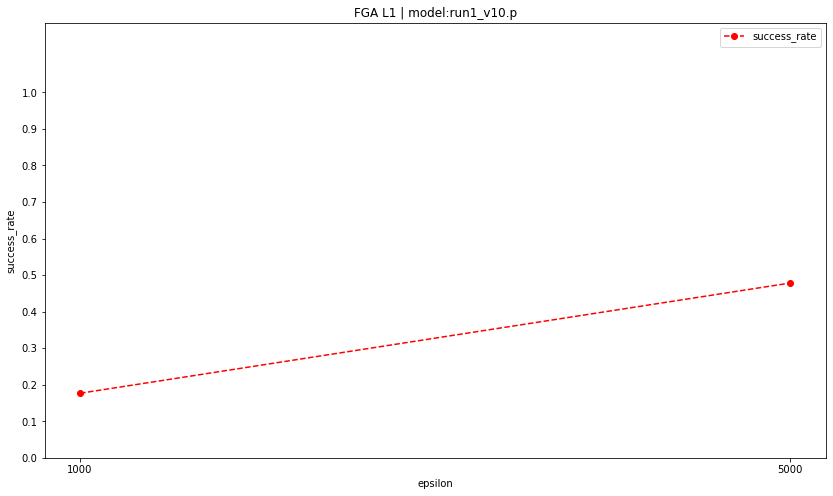

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"
Robustness-Performance:  3.1606401896858323


[I 2020-06-21 14:47:24,604] Finished trial#10 with value: 3.1606401896858323 with parameters: {'batch_size': 64, 'learning_rate': 0.002702178859947923, 'p_drop': 0.4288068122716165, 'lr_decay': 0.8001712613594595, 'weight_decay': 0.0791441368577516, 'eps_up': 1.1604507322838784}. Best is trial#3 with value: 4.1096621221102545.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

   | Name           | Type         | Params
-----------------------------------

Val-Acc=0.03852993479549496


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.5103734439834025


Val-Acc=0.4896265560165975


Val-Acc=0.5103734439834025


Val-Acc=0.5103734439834025


Val-Acc=0.5103734439834025


Val-Acc=0.5103734439834025


Val-Acc=0.5103734439834025


Val-Acc=0.5103734439834025


Val-Acc=0.5103734439834025


Val-Acc=0.5103734439834025


Val-Acc=0.5103734439834025


Val-Acc=0.5103734439834025


Val-Acc=0.5103734439834025


Val-Acc=0.5103734439834025


Val-Acc=0.5103734439834025


Val-Acc=0.5103734439834025


Val-Acc=0.5103734439834025


Val-Acc=0.5103734439834025


Val-Acc=0.5103734439834025


Val-Acc=0.5103734439834025

Saved model to "saved_models/run1_v11.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/2 [00:00<?, ?it/s]



Running experiment on model run1_v11.p
Created Dir '/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/run1_v11.p'

Perform Attack #1/3: FGSM


100%|██████████| 2/2 [00:06<00:00,  3.36s/it]


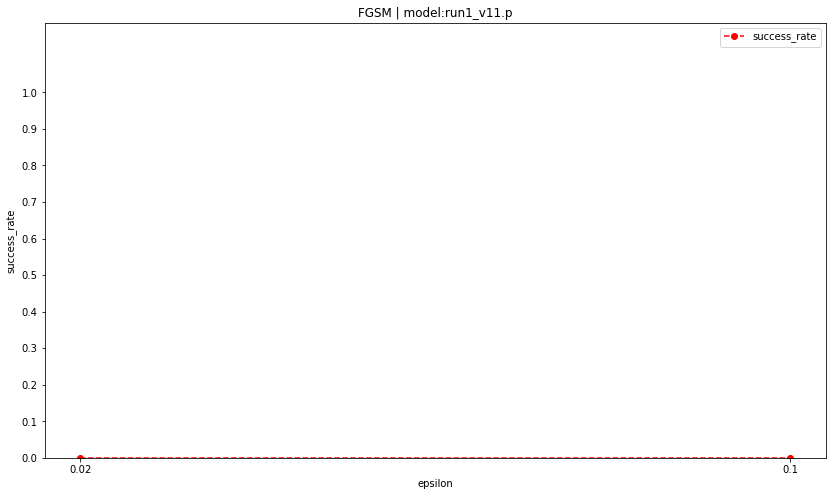

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #2/3: FGA L2


100%|██████████| 2/2 [00:06<00:00,  3.25s/it]


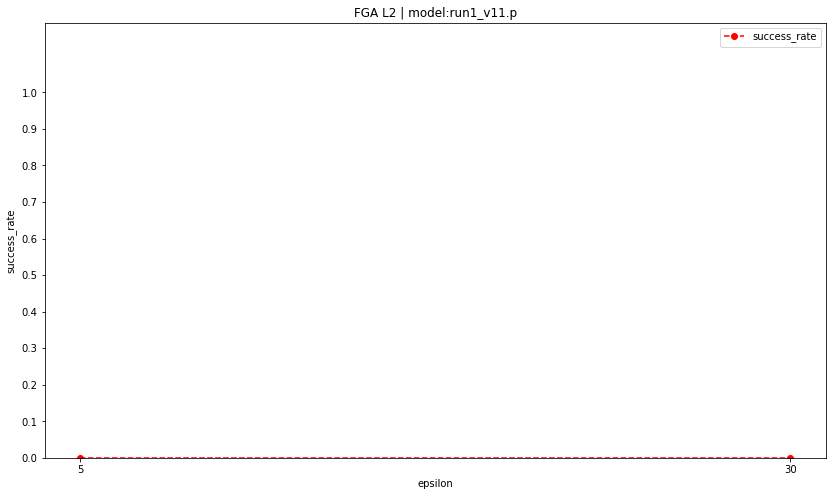

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #3/3: FGA L1


100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


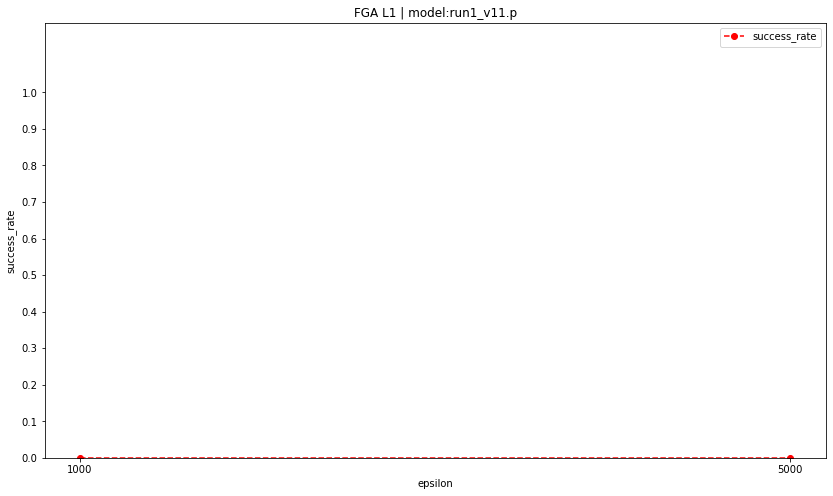

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"
Robustness-Performance:  3.0622406639004147


[I 2020-06-21 14:54:53,407] Finished trial#11 with value: 3.0622406639004147 with parameters: {'batch_size': 64, 'learning_rate': 0.07421035774483768, 'p_drop': 0.33084258613102163, 'lr_decay': 0.9919967147397151, 'weight_decay': 0.061323815992473524, 'eps_up': 145.09949009418708}. Best is trial#3 with value: 4.1096621221102545.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

   | Name           | Type         | Params
---------------------------------

Val-Acc=0.03793716656787196


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.5091879075281565


Val-Acc=0.5085951393005335


Val-Acc=0.5103734439834025


Val-Acc=0.5103734439834025


Val-Acc=0.5103734439834025


Val-Acc=0.5103734439834025


Val-Acc=0.5103734439834025


Val-Acc=0.5103734439834025


Val-Acc=0.5103734439834025


Val-Acc=0.5103734439834025


Val-Acc=0.5103734439834025


Val-Acc=0.5103734439834025


Val-Acc=0.5103734439834025


Val-Acc=0.5103734439834025


Val-Acc=0.5103734439834025


Val-Acc=0.5103734439834025


Val-Acc=0.5103734439834025


Val-Acc=0.5103734439834025


Val-Acc=0.5103734439834025


Val-Acc=0.5103734439834025

Saved model to "saved_models/run1_v12.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/2 [00:00<?, ?it/s]



Running experiment on model run1_v12.p
Created Dir '/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/run1_v12.p'

Perform Attack #1/3: FGSM


100%|██████████| 2/2 [00:06<00:00,  3.35s/it]


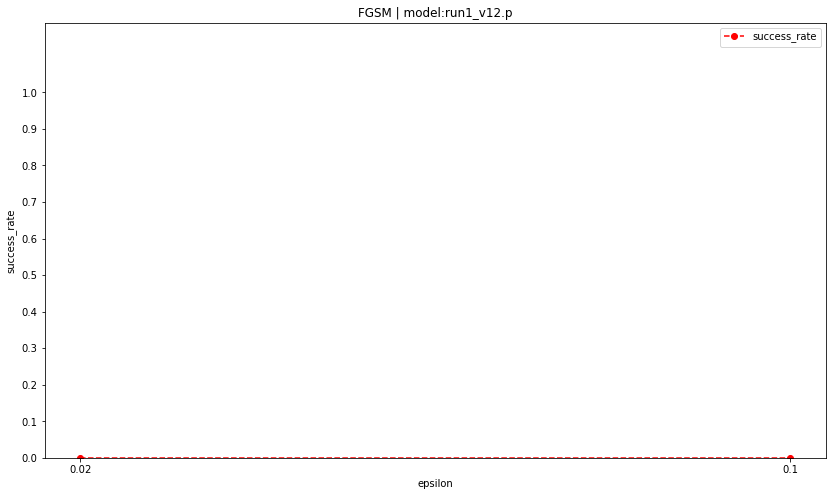

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #2/3: FGA L2


100%|██████████| 2/2 [00:06<00:00,  3.24s/it]


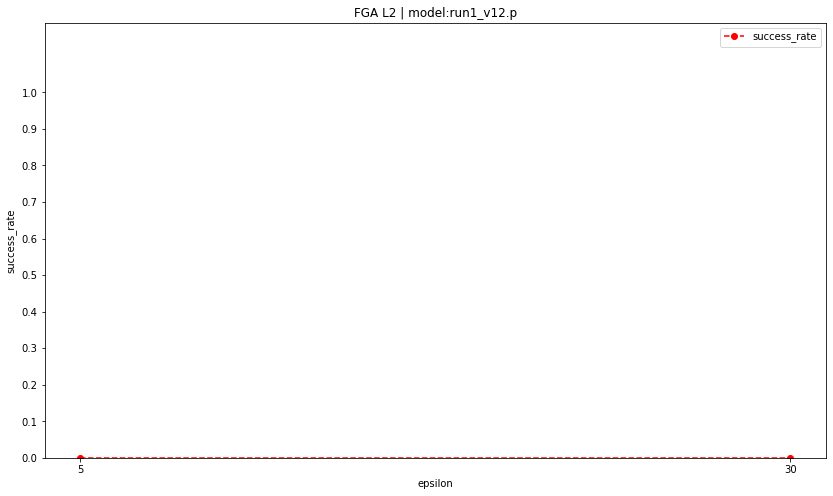

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #3/3: FGA L1


100%|██████████| 2/2 [00:06<00:00,  3.24s/it]


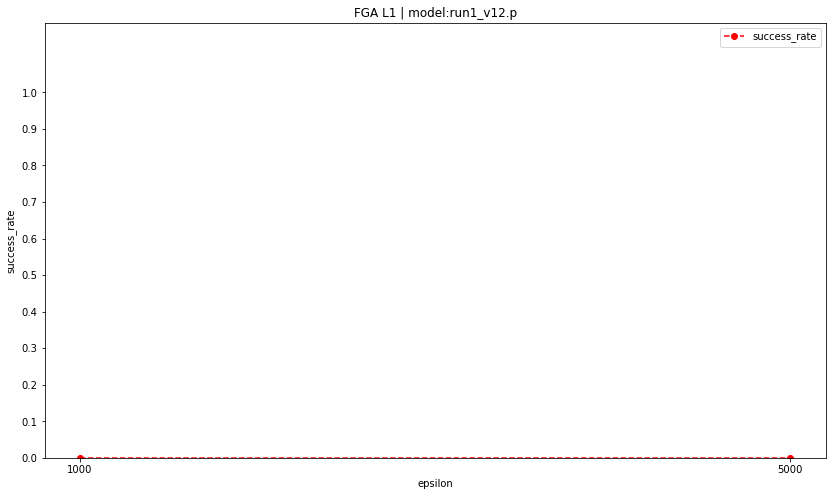

[I 2020-06-21 15:02:18,628] Finished trial#12 with value: 3.0622406639004147 with parameters: {'batch_size': 64, 'learning_rate': 0.08587997334045672, 'p_drop': 0.31927648222819865, 'lr_decay': 0.9307462766969399, 'weight_decay': 0.06542073238043379, 'eps_up': 98.85136016878921}. Best is trial#3 with value: 4.1096621221102545.


Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"
Robustness-Performance:  3.0622406639004147


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

   | Name           | Type         | Params
--------------------------------------------
0  | model          | M5           | 555 K 
1  | model.model    | Sequential   | 555 K 
2  | model.model.0  | Conv1d       | 10 K  
3  | model.model.1  | BatchNorm1d  | 256   
4  | model.model.2  | MaxPool1d    | 0     
5  | model.model.3  | Dropout      | 0     
6  | model.model.4  | Conv1d       | 49 K  
7  | model.

Val-Acc=0.03793716656787196


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.6609365737996443


Val-Acc=0.7646710136336692


Val-Acc=0.7634854771784232


Val-Acc=0.7148784825133373


Val-Acc=0.7949021932424422


Val-Acc=0.7848251333728512


Val-Acc=0.7800829875518672


Val-Acc=0.7954949614700652


Val-Acc=0.7077652637818613


Val-Acc=0.8085358624777712


Val-Acc=0.8209839952578541


Val-Acc=0.8245406046235921


Val-Acc=0.8049792531120332


Val-Acc=0.8340248962655602


Val-Acc=0.7818612922347362


Val-Acc=0.6870183758150563


Val-Acc=0.7824540604623592


Val-Acc=0.8429164196799052


Val-Acc=0.7771191464137522


Val-Acc=0.6899822169531713

Saved model to "saved_models/run1_v13.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/2 [00:00<?, ?it/s]



Running experiment on model run1_v13.p
Created Dir '/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/run1_v13.p'

Perform Attack #1/3: FGSM


100%|██████████| 2/2 [00:07<00:00,  3.99s/it]


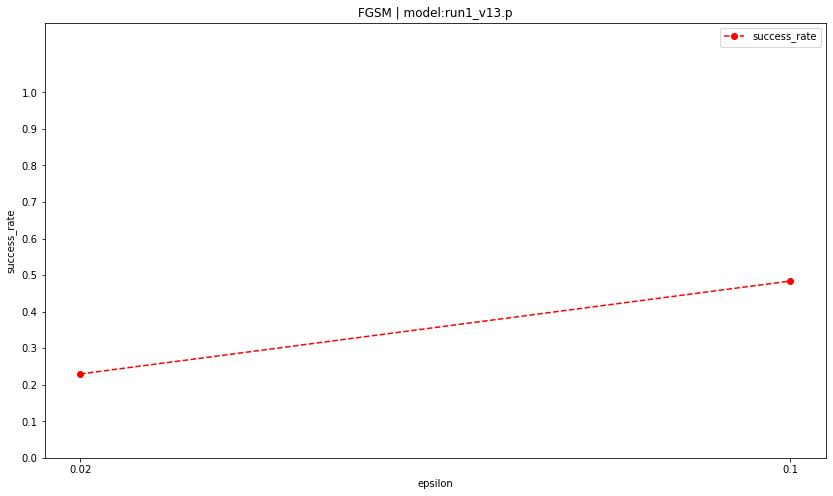

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #2/3: FGA L2


100%|██████████| 2/2 [00:07<00:00,  3.88s/it]


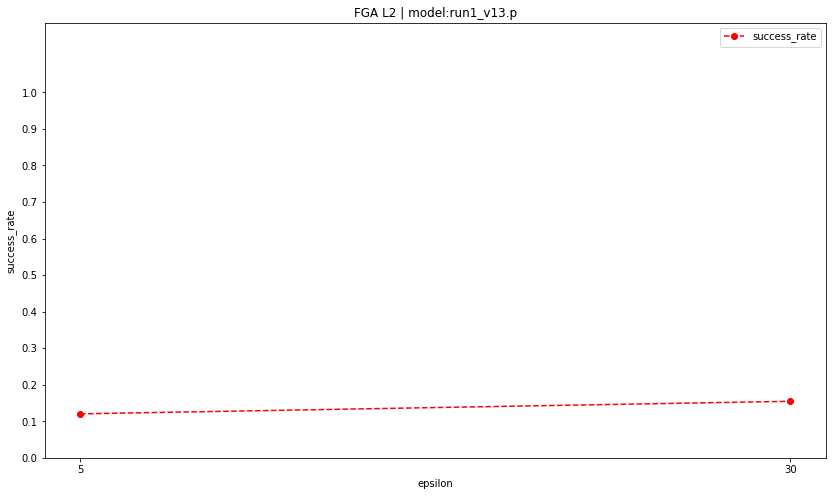

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #3/3: FGA L1


100%|██████████| 2/2 [00:08<00:00,  4.03s/it]


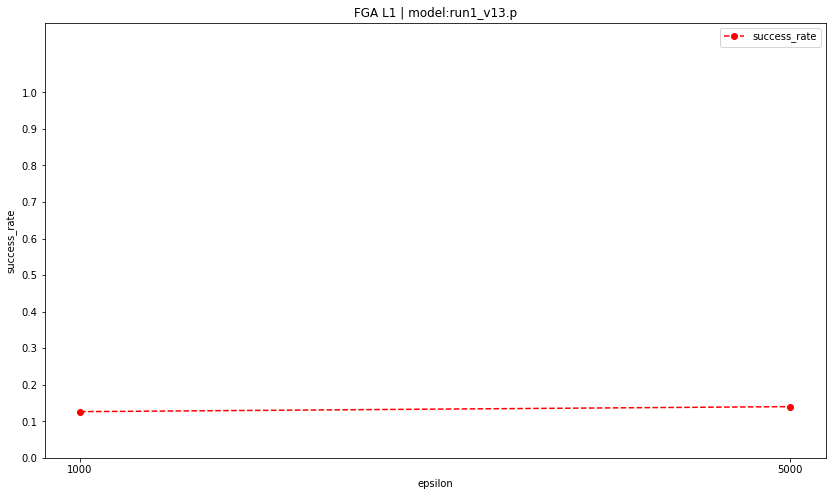

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"
Robustness-Performance:  3.2744516893894486


[I 2020-06-21 15:09:56,283] Finished trial#13 with value: 3.2744516893894486 with parameters: {'batch_size': 64, 'learning_rate': 0.00956952686871937, 'p_drop': 0.27349044164333813, 'lr_decay': 0.9965651509245745, 'weight_decay': 0.038660862789975214, 'eps_up': 60.82235622365956}. Best is trial#3 with value: 4.1096621221102545.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

   | Name           | Type         | Params
----------------------------------

Val-Acc=0.03438055720213397


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.6627148784825133


Val-Acc=0.7279193835210432


Val-Acc=0.7848251333728512


Val-Acc=0.5305275637225845


Val-Acc=0.5103734439834025


Val-Acc=0.6336692353289863


Val-Acc=0.7178423236514523


Val-Acc=0.7949021932424422


Val-Acc=0.7593360995850622


Val-Acc=0.7771191464137522


Val-Acc=0.8180201541197392


Val-Acc=0.8346176644931832


Val-Acc=0.8328393598103142


Val-Acc=0.8209839952578541


Val-Acc=0.8263189093064611


Val-Acc=0.8221695317131001


Val-Acc=0.8239478363959691


Val-Acc=0.8227622999407231


Val-Acc=0.8162418494368702


Val-Acc=0.8020154119739182

Saved model to "saved_models/run1_v14.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/2 [00:00<?, ?it/s]



Running experiment on model run1_v14.p
Created Dir '/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/run1_v14.p'

Perform Attack #1/3: FGSM


100%|██████████| 2/2 [00:08<00:00,  4.45s/it]


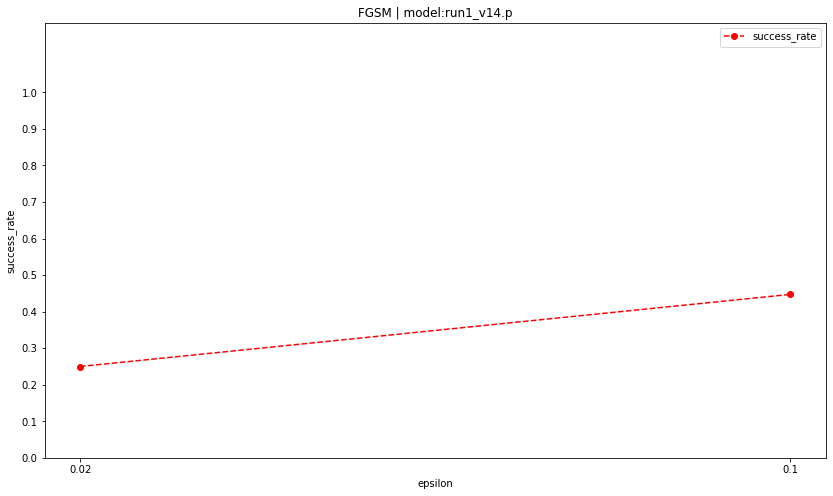

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #2/3: FGA L2


100%|██████████| 2/2 [00:08<00:00,  4.35s/it]


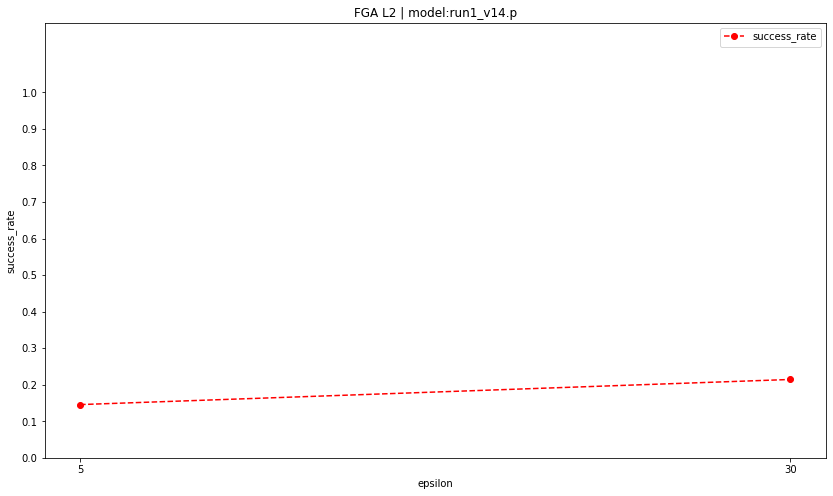

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #3/3: FGA L1


100%|██████████| 2/2 [00:08<00:00,  4.34s/it]


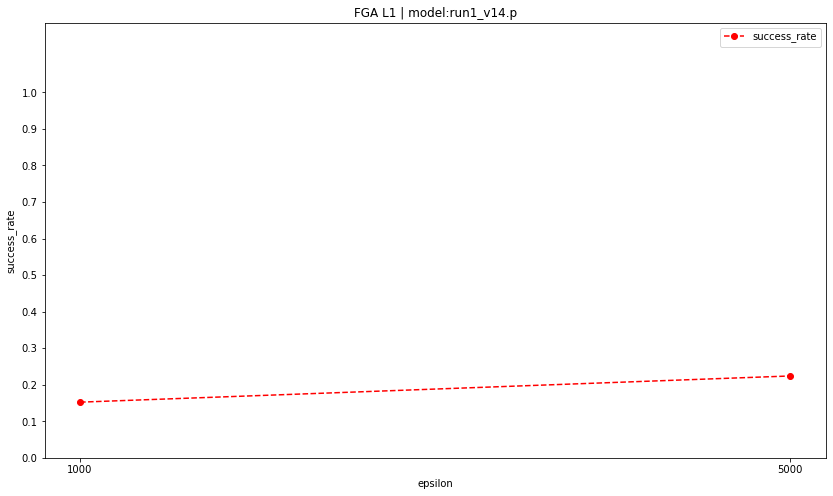

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"
Robustness-Performance:  3.6627148784825128


[I 2020-06-21 15:17:33,780] Finished trial#14 with value: 3.6627148784825128 with parameters: {'batch_size': 64, 'learning_rate': 0.023970491374384232, 'p_drop': 0.3963354766135454, 'lr_decay': 0.8094432002010635, 'weight_decay': 0.06581971352552743, 'eps_up': 22.508151395350705}. Best is trial#3 with value: 4.1096621221102545.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

   | Name           | Type         | Params
----------------------------------

Val-Acc=0.03793716656787196


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.7557794902193242


Val-Acc=0.8138707765263782


Val-Acc=0.7652637818612922


Val-Acc=0.8215767634854771


Val-Acc=0.7972732661529343


Val-Acc=0.8032009484291642


Val-Acc=0.7593360995850622


Val-Acc=0.8138707765263782


Val-Acc=0.7794902193242442


Val-Acc=0.8150563129816242


Val-Acc=0.8186129223473622


Val-Acc=0.8103141671606402


Val-Acc=0.7504445761707172


Val-Acc=0.8114997036158862


Val-Acc=0.8233550681683461


Val-Acc=0.8197984588026082


Val-Acc=0.7895672791938352


Val-Acc=0.8233550681683461


Val-Acc=0.8227622999407231


Val-Acc=0.7954949614700652

Saved model to "saved_models/run1_v15.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/2 [00:00<?, ?it/s]



Running experiment on model run1_v15.p
Created Dir '/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/run1_v15.p'

Perform Attack #1/3: FGSM


100%|██████████| 2/2 [00:08<00:00,  4.40s/it]


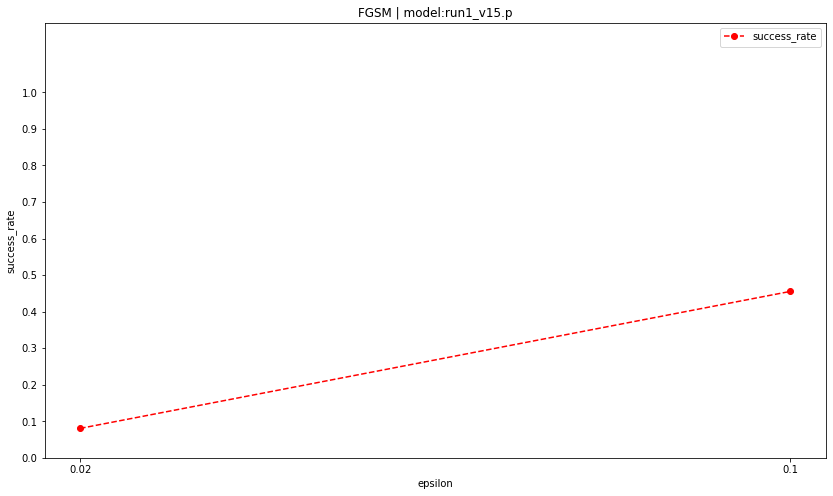

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #2/3: FGA L2


100%|██████████| 2/2 [00:08<00:00,  4.31s/it]


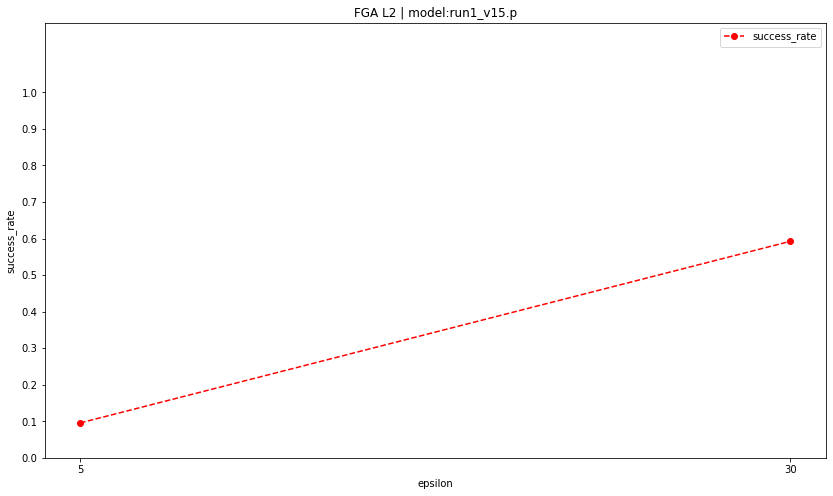

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #3/3: FGA L1


100%|██████████| 2/2 [00:08<00:00,  4.31s/it]


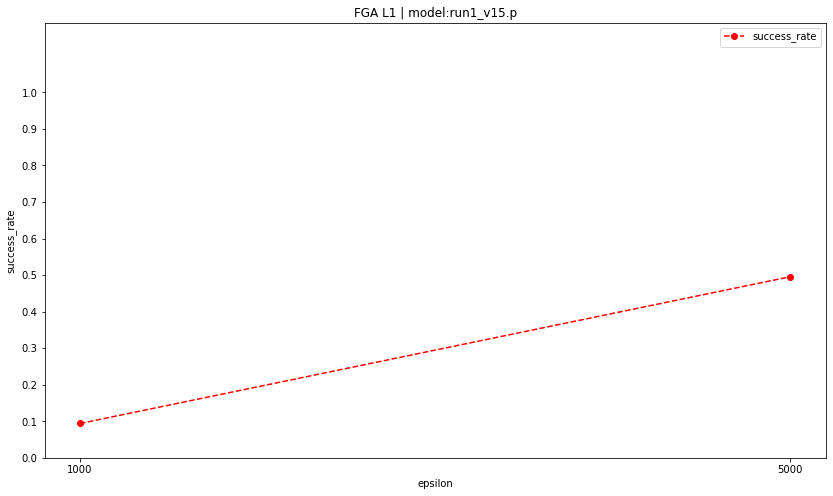

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"
Robustness-Performance:  3.330764671013634


[I 2020-06-21 15:25:13,339] Finished trial#15 with value: 3.330764671013634 with parameters: {'batch_size': 64, 'learning_rate': 0.0017189109794278762, 'p_drop': 0.022662131837845795, 'lr_decay': 0.9027825143104905, 'weight_decay': 0.05026849363566984, 'eps_up': 3.449608216093751}. Best is trial#3 with value: 4.1096621221102545.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

   | Name           | Type         | Params
---------------------------------

Val-Acc=0.046235921754593956


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.6887966804979253


Val-Acc=0.7522228808535862


Val-Acc=0.7368109069353883


Val-Acc=0.7812685240071132


Val-Acc=0.7806757557794902


Val-Acc=0.7617071724955542


Val-Acc=0.7812685240071132


Val-Acc=0.7794902193242442


Val-Acc=0.7729697688203913


Val-Acc=0.7569650266745702


Val-Acc=0.7705986959098993


Val-Acc=0.7670420865441613


Val-Acc=0.7611144042679312


Val-Acc=0.7474807350326023


Val-Acc=0.7184350918790753


Val-Acc=0.6804979253112033


Val-Acc=0.7528156490812092


Val-Acc=0.7107291049199763


Val-Acc=0.7581505631298162


Val-Acc=0.7765263781861292

Saved model to "saved_models/run1_v16.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/2 [00:00<?, ?it/s]



Running experiment on model run1_v16.p
Created Dir '/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/run1_v16.p'

Perform Attack #1/3: FGSM


100%|██████████| 2/2 [00:08<00:00,  4.35s/it]


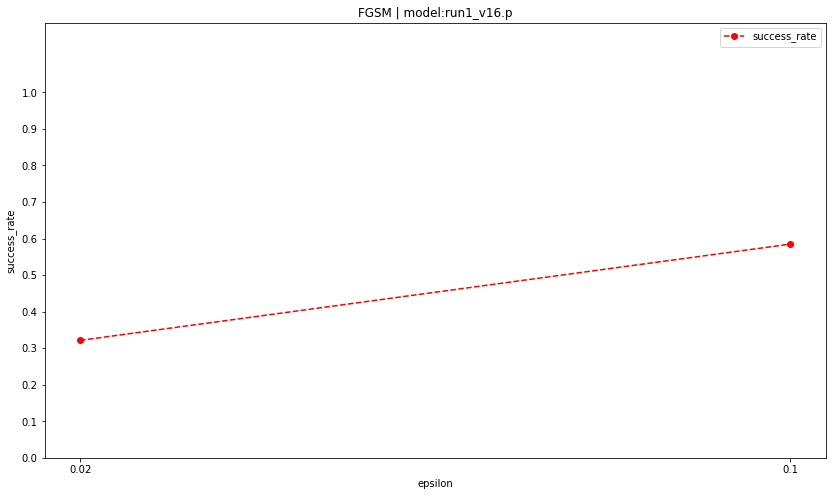

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #2/3: FGA L2


100%|██████████| 2/2 [00:08<00:00,  4.26s/it]


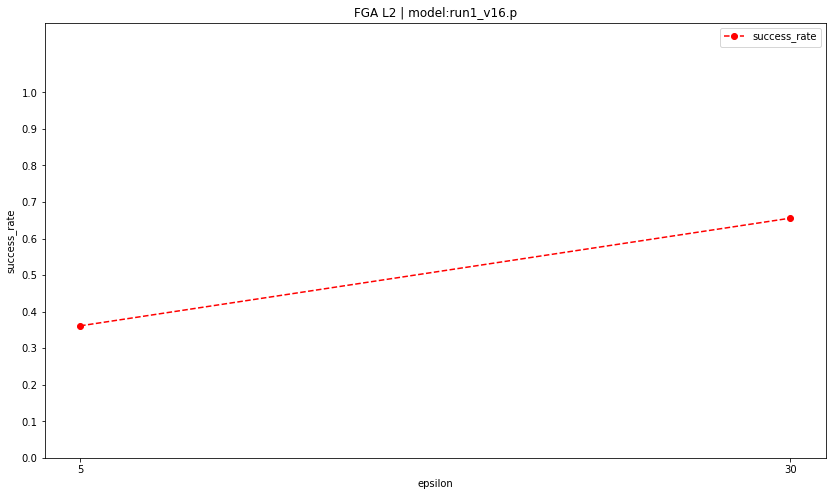

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #3/3: FGA L1


100%|██████████| 2/2 [00:08<00:00,  4.26s/it]


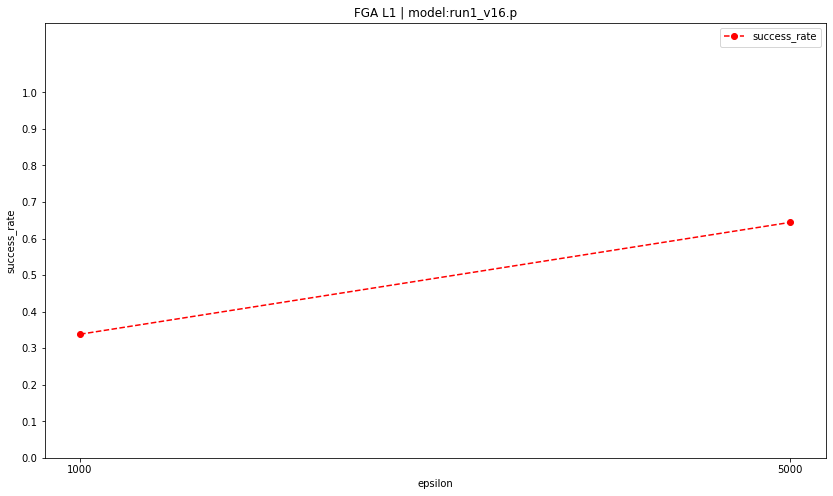

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"
Robustness-Performance:  2.4030823947836395


[I 2020-06-21 15:32:49,454] Finished trial#16 with value: 2.4030823947836395 with parameters: {'batch_size': 64, 'learning_rate': 8.621850665428366e-06, 'p_drop': 0.25967361120661436, 'lr_decay': 0.9701646135165106, 'weight_decay': 0.07789519457806149, 'eps_up': 16.196255283214626}. Best is trial#3 with value: 4.1096621221102545.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

   | Name           | Type         | Params
--------------------------------

Val-Acc=0.03793716656787196


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.7741553052756373


Val-Acc=0.7267338470657972


Val-Acc=0.7451096621221103


Val-Acc=0.5210432720806165


Val-Acc=0.6976882039122703


Val-Acc=0.7213989330171903


Val-Acc=0.7759336099585062


Val-Acc=0.6639004149377593


Val-Acc=0.6763485477178424


Val-Acc=0.6573799644339063


Val-Acc=0.7409602845287493


Val-Acc=0.7439241256668643


Val-Acc=0.6627148784825133


Val-Acc=0.6550088915234143


Val-Acc=0.6004742145820984


Val-Acc=0.6775340841730884


Val-Acc=0.7860106698280972


Val-Acc=0.8363959691760522


Val-Acc=0.7154712507409603


Val-Acc=0.7468879668049793

Saved model to "saved_models/run1_v17.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/2 [00:00<?, ?it/s]



Running experiment on model run1_v17.p
Created Dir '/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/run1_v17.p'

Perform Attack #1/3: FGSM


100%|██████████| 2/2 [00:08<00:00,  4.20s/it]


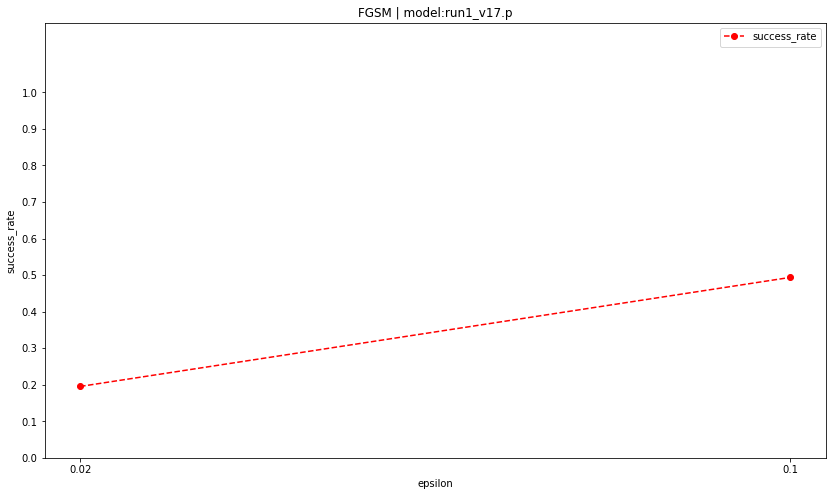

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #2/3: FGA L2


100%|██████████| 2/2 [00:08<00:00,  4.11s/it]


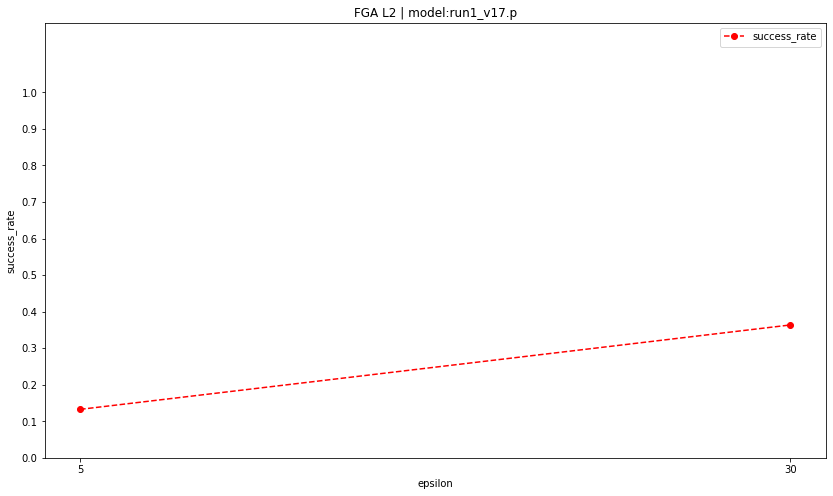

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #3/3: FGA L1


100%|██████████| 2/2 [00:08<00:00,  4.11s/it]


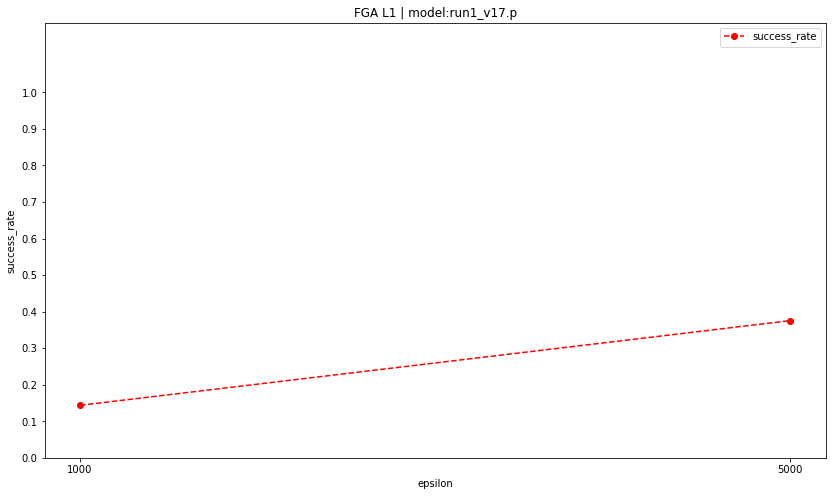

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"
Robustness-Performance:  3.208654416123296


[I 2020-06-21 15:40:30,447] Finished trial#17 with value: 3.208654416123296 with parameters: {'batch_size': 64, 'learning_rate': 0.03172807455222969, 'p_drop': 0.414261660870457, 'lr_decay': 0.9137357274724582, 'weight_decay': 0.021463220565022537, 'eps_up': 48.07297832894214}. Best is trial#3 with value: 4.1096621221102545.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

   | Name           | Type         | Params
-------------------------------------

Val-Acc=0.03793716656787196


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.7860106698280972


Val-Acc=0.7771191464137522


Val-Acc=0.8085358624777712


Val-Acc=0.8049792531120332


Val-Acc=0.7907528156490812


Val-Acc=0.7972732661529343


Val-Acc=0.8215767634854771


Val-Acc=0.7611144042679312


Val-Acc=0.8055720213396562


Val-Acc=0.7954949614700652


Val-Acc=0.7000592768227623


Val-Acc=0.8132780082987552


Val-Acc=0.8221695317131001


Val-Acc=0.7747480735032602


Val-Acc=0.8192056905749852


Val-Acc=0.8168346176644932


Val-Acc=0.8280972139893301


Val-Acc=0.8197984588026082


Val-Acc=0.8239478363959691


Val-Acc=0.8120924718435092

Saved model to "saved_models/run1_v18.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/2 [00:00<?, ?it/s]



Running experiment on model run1_v18.p
Created Dir '/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/run1_v18.p'

Perform Attack #1/3: FGSM


100%|██████████| 2/2 [00:09<00:00,  4.60s/it]


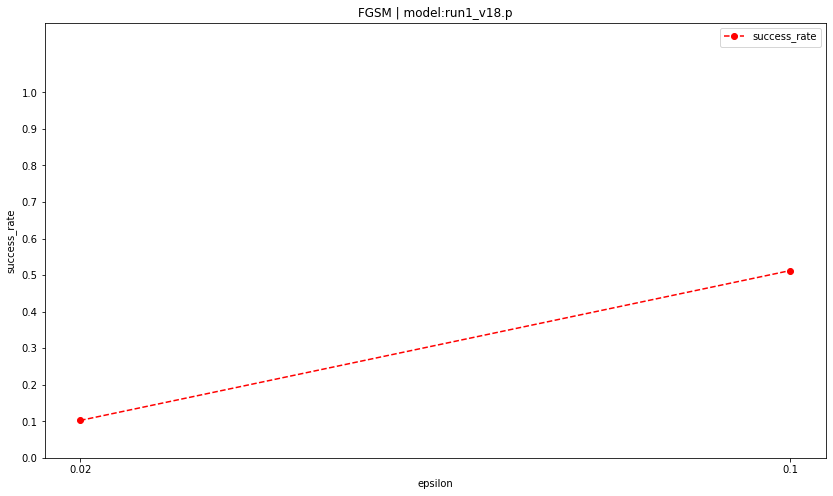

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #2/3: FGA L2


100%|██████████| 2/2 [00:08<00:00,  4.40s/it]


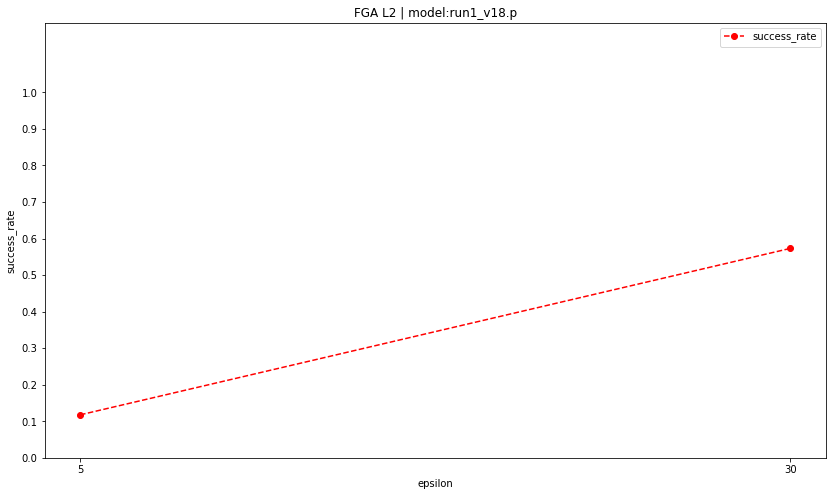

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #3/3: FGA L1


100%|██████████| 2/2 [00:08<00:00,  4.40s/it]


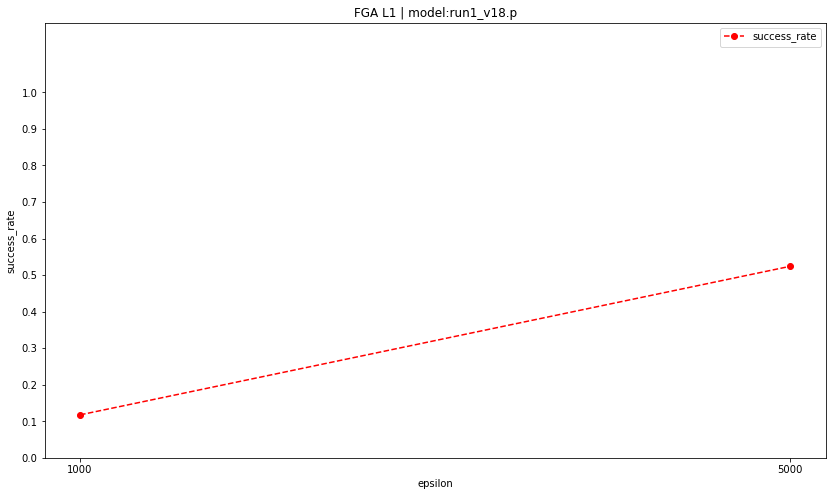

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"
Robustness-Performance:  3.291641967990516


[I 2020-06-21 15:48:07,571] Finished trial#18 with value: 3.291641967990516 with parameters: {'batch_size': 64, 'learning_rate': 0.0018662994727615967, 'p_drop': 0.36870316262403247, 'lr_decay': 0.8798145695708545, 'weight_decay': 0.057837107527133946, 'eps_up': 1.7161522976750858}. Best is trial#3 with value: 4.1096621221102545.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

   | Name           | Type         | Params
--------------------------------

Val-Acc=0.03141671606401897


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.7842323651452282


Val-Acc=0.7806757557794902


Val-Acc=0.7024303497332542


Val-Acc=0.7575577949021932


Val-Acc=0.8109069353882632


Val-Acc=0.7895672791938352


Val-Acc=0.8209839952578541


Val-Acc=0.8055720213396562


Val-Acc=0.6650859513930053


Val-Acc=0.7705986959098993


Val-Acc=0.6959098992294013


Val-Acc=0.5607587433313574


Val-Acc=0.6247777119146414


Val-Acc=0.6360403082394783


Val-Acc=0.6378186129223473


Val-Acc=0.5969176052163604


Val-Acc=0.5981031416716064


Val-Acc=0.5892116182572614


Val-Acc=0.5737996443390634


Val-Acc=0.6170717249555424

Saved model to "saved_models/run1_v19.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/2 [00:00<?, ?it/s]



Running experiment on model run1_v19.p
Created Dir '/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/run1_v19.p'

Perform Attack #1/3: FGSM


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


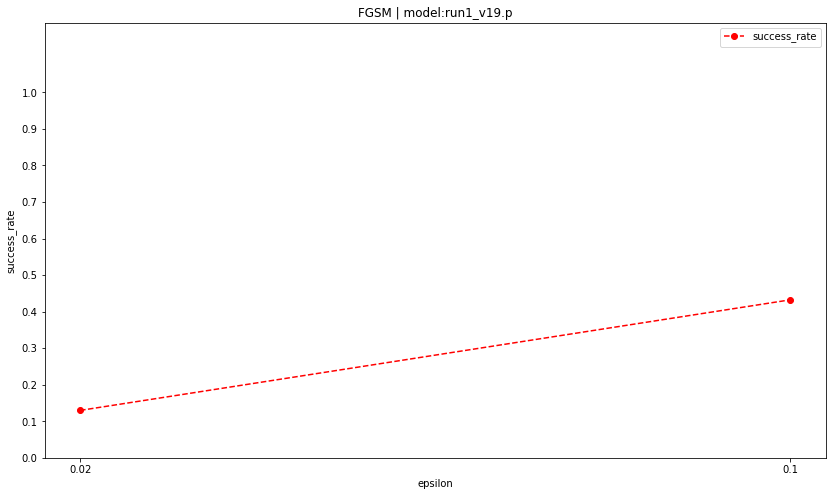

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #2/3: FGA L2


100%|██████████| 2/2 [00:07<00:00,  3.64s/it]


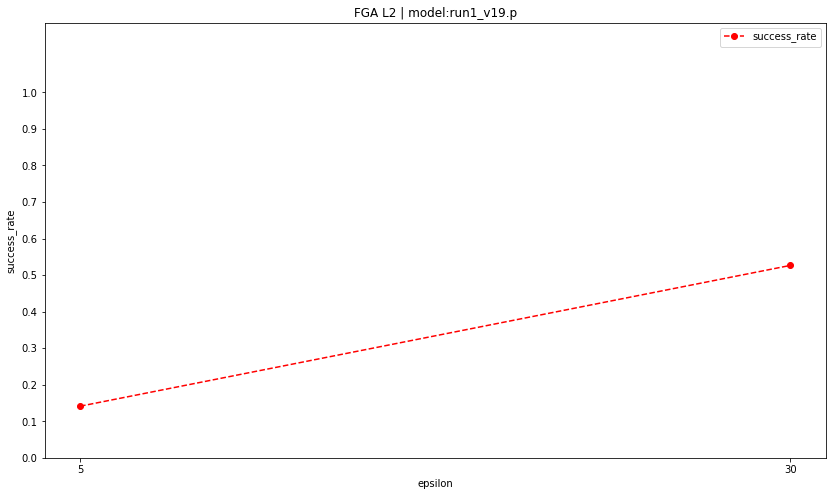

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #3/3: FGA L1


100%|██████████| 2/2 [00:07<00:00,  3.64s/it]


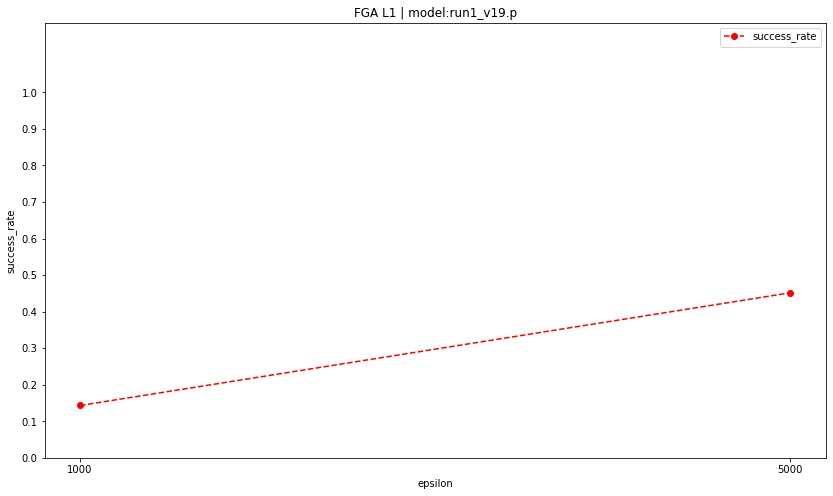

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"
Robustness-Performance:  2.576763485477178


[I 2020-06-21 15:55:31,936] Finished trial#19 with value: 2.576763485477178 with parameters: {'batch_size': 64, 'learning_rate': 0.006602223381673749, 'p_drop': 0.28229424316110574, 'lr_decay': 0.8207895643072046, 'weight_decay': 0.04029051320712468, 'eps_up': 4.356534232496729}. Best is trial#3 with value: 4.1096621221102545.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

   | Name           | Type         | Params
-----------------------------------

Val-Acc=0.03793716656787196


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.4997036158861885


Val-Acc=0.6650859513930053


Val-Acc=0.6704208654416123


Val-Acc=0.6668642560758743


Val-Acc=0.7700059276822763


Val-Acc=0.7949021932424422


Val-Acc=0.7101363366923533


Val-Acc=0.7415530527563723


Val-Acc=0.7113218731475993


Val-Acc=0.7788974510966212


Val-Acc=0.5352697095435685


Val-Acc=0.7154712507409603


Val-Acc=0.5157083580320095


Val-Acc=0.8014226437462952


Val-Acc=0.7184350918790753


Val-Acc=0.6188500296384114


Val-Acc=0.5975103734439834


Val-Acc=0.7717842323651453


Val-Acc=0.7937166567871962


Val-Acc=0.7670420865441613

Saved model to "saved_models/run1_v20.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/2 [00:00<?, ?it/s]



Running experiment on model run1_v20.p
Created Dir '/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/run1_v20.p'

Perform Attack #1/3: FGSM


100%|██████████| 2/2 [00:08<00:00,  4.30s/it]


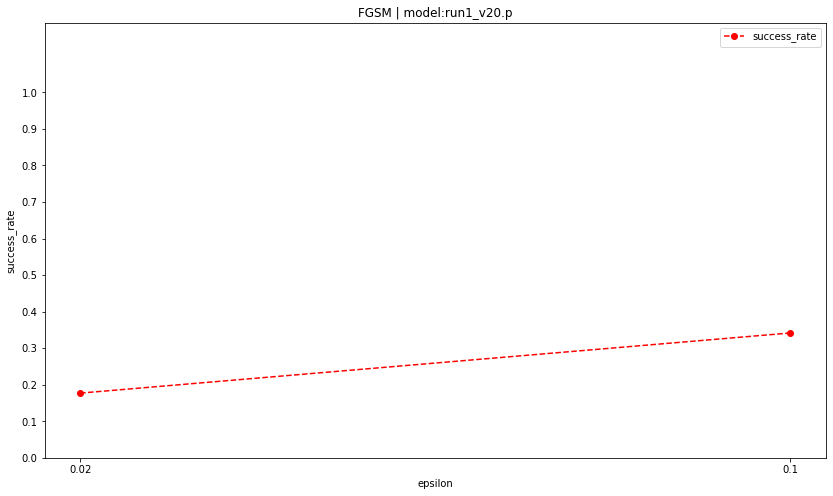

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #2/3: FGA L2


100%|██████████| 2/2 [00:08<00:00,  4.47s/it]


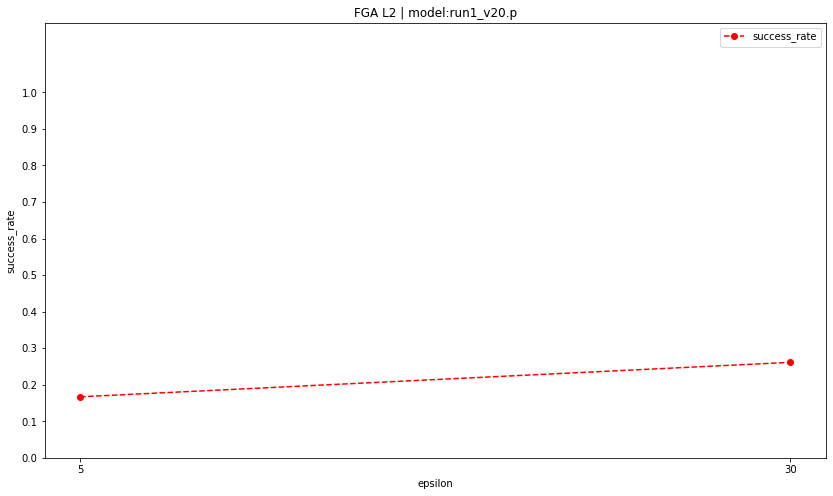

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #3/3: FGA L1


100%|██████████| 2/2 [00:08<00:00,  4.21s/it]


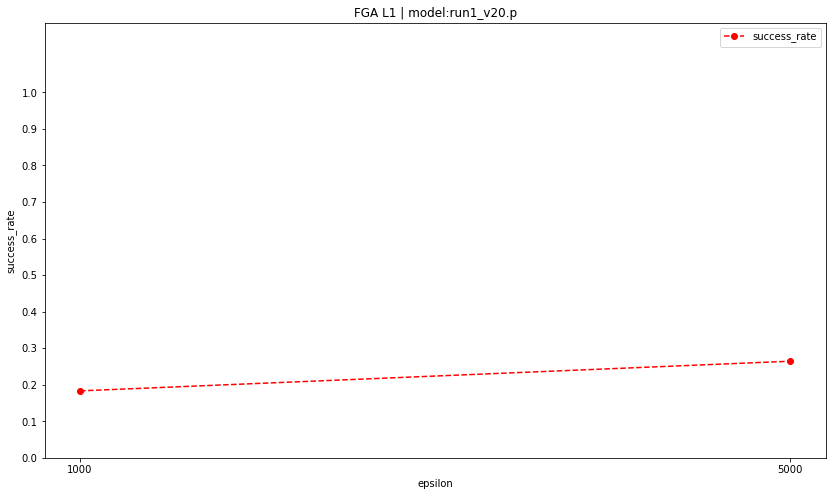

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"
Robustness-Performance:  3.5328986366330764


[I 2020-06-21 16:02:58,391] Finished trial#20 with value: 3.5328986366330764 with parameters: {'batch_size': 64, 'learning_rate': 0.04025989971130295, 'p_drop': 0.48302933412646903, 'lr_decay': 0.9502994690336102, 'weight_decay': 0.09152181007805923, 'eps_up': 141.2919250761914}. Best is trial#3 with value: 4.1096621221102545.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

   | Name           | Type         | Params
-----------------------------------

Val-Acc=0.03852993479549496


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.5121517486662714


Val-Acc=0.7557794902193242


Val-Acc=0.7877889745109662


Val-Acc=0.7806757557794902


Val-Acc=0.7788974510966212


Val-Acc=0.7042086544161233


Val-Acc=0.8180201541197392


Val-Acc=0.7854179016004742


Val-Acc=0.8091286307053942


Val-Acc=0.8322465915826912


Val-Acc=0.8322465915826912


Val-Acc=0.8233550681683461


Val-Acc=0.8334321280379372


Val-Acc=0.7308832246591582


Val-Acc=0.7356253704801423


Val-Acc=0.7658565500889153


Val-Acc=0.8209839952578541


Val-Acc=0.7777119146413752


Val-Acc=0.8328393598103142


Val-Acc=0.7943094250148192

Saved model to "saved_models/run1_v21.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/2 [00:00<?, ?it/s]



Running experiment on model run1_v21.p
Created Dir '/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/run1_v21.p'

Perform Attack #1/3: FGSM


100%|██████████| 2/2 [00:08<00:00,  4.45s/it]


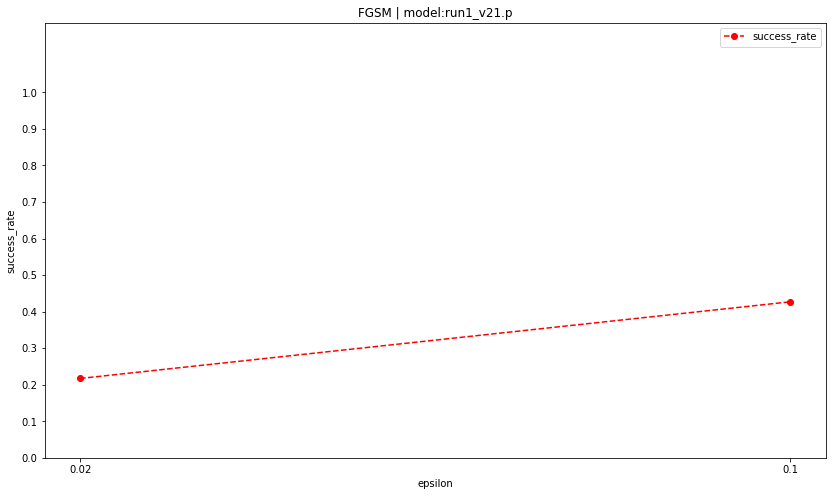

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #2/3: FGA L2


100%|██████████| 2/2 [00:08<00:00,  4.33s/it]


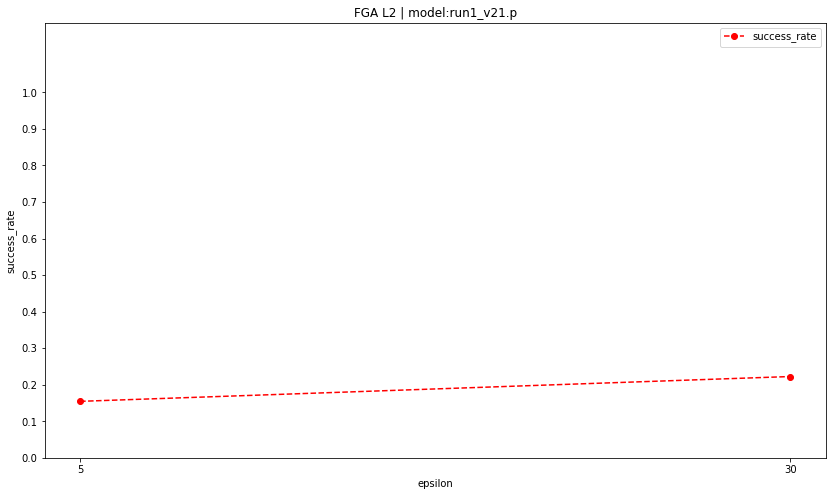

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #3/3: FGA L1


100%|██████████| 2/2 [00:08<00:00,  4.37s/it]


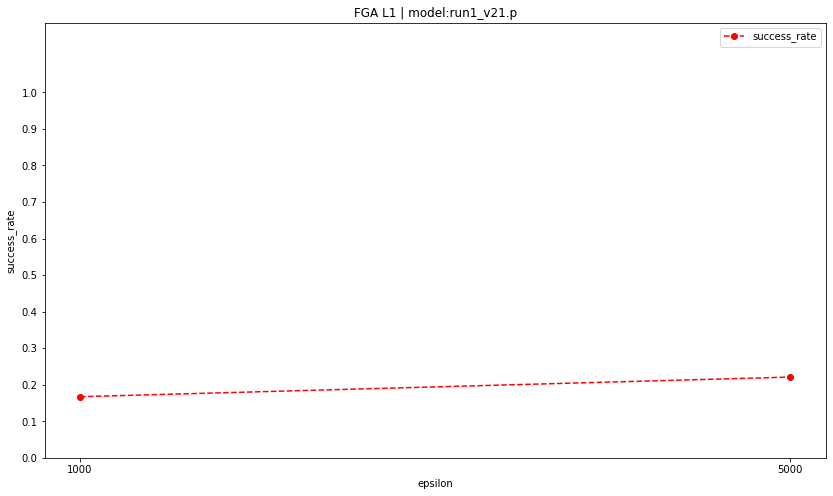

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"
Robustness-Performance:  3.646710136336692


[I 2020-06-21 16:10:34,616] Finished trial#21 with value: 3.646710136336692 with parameters: {'batch_size': 64, 'learning_rate': 0.01739932803436937, 'p_drop': 0.39226157881179735, 'lr_decay': 0.8015750016459632, 'weight_decay': 0.0694532207688513, 'eps_up': 16.441443890619706}. Best is trial#3 with value: 4.1096621221102545.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

   | Name           | Type         | Params
------------------------------------

Val-Acc=0.03852993479549496


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.7208061647895673


Val-Acc=0.7385892116182573


Val-Acc=0.7771191464137522


Val-Acc=0.7273266152934202


Val-Acc=0.8144635447540012


Val-Acc=0.7783046828689982


Val-Acc=0.7107291049199763


Val-Acc=0.8014226437462952


Val-Acc=0.7474807350326023


Val-Acc=0.6769413159454654


Val-Acc=0.7960877296976882


Val-Acc=0.7949021932424422


Val-Acc=0.8120924718435092


Val-Acc=0.8043864848844102


Val-Acc=0.8014226437462952


Val-Acc=0.7972732661529343


Val-Acc=0.8304682868998222


Val-Acc=0.8310610551274452


Val-Acc=0.8316538233550682


Val-Acc=0.8298755186721992

Saved model to "saved_models/run1_v22.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/2 [00:00<?, ?it/s]



Running experiment on model run1_v22.p
Created Dir '/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/run1_v22.p'

Perform Attack #1/3: FGSM


100%|██████████| 2/2 [00:09<00:00,  4.55s/it]


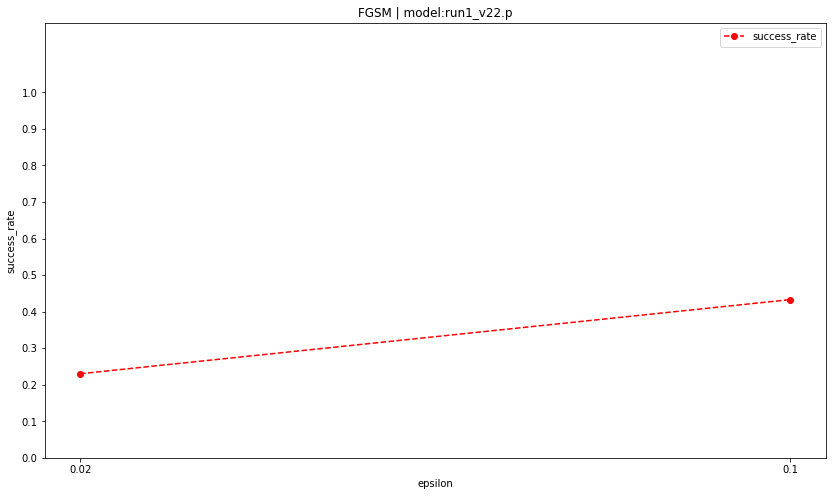

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #2/3: FGA L2


100%|██████████| 2/2 [00:08<00:00,  4.45s/it]


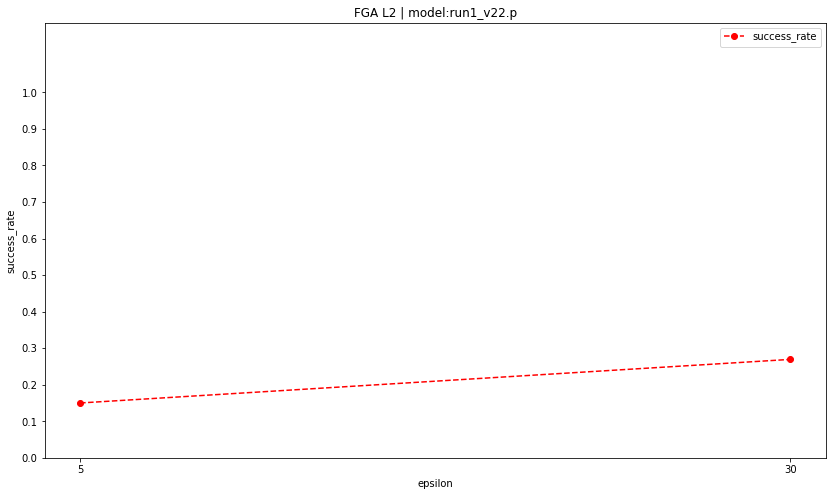

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #3/3: FGA L1


100%|██████████| 2/2 [00:09<00:00,  4.61s/it]


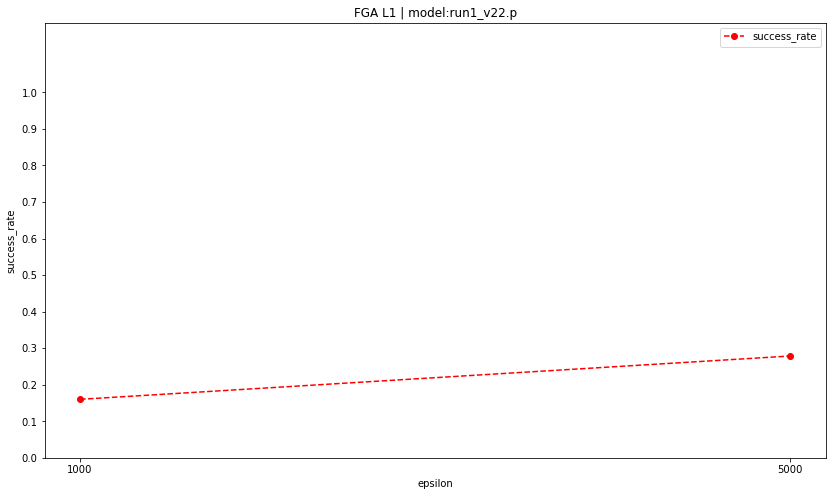

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"
Robustness-Performance:  3.7172495554238294


[I 2020-06-21 16:18:10,457] Finished trial#22 with value: 3.7172495554238294 with parameters: {'batch_size': 64, 'learning_rate': 0.029224577361777374, 'p_drop': 0.43572012694674067, 'lr_decay': 0.8250367307533366, 'weight_decay': 0.0713784942692264, 'eps_up': 68.38888537899048}. Best is trial#3 with value: 4.1096621221102545.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

   | Name           | Type         | Params
-----------------------------------

Val-Acc=0.036751630112625965


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.7160640189685833


Val-Acc=0.5020746887966805


Val-Acc=0.6484884410195614


Val-Acc=0.5690574985180794


Val-Acc=0.6010669828097214


Val-Acc=0.4908120924718435


Val-Acc=0.4914048606994665


Val-Acc=0.4943687018375815


Val-Acc=0.5174866627148785


Val-Acc=0.5459395376407824


Val-Acc=0.5512744516893895


Val-Acc=0.4914048606994665


Val-Acc=0.4896265560165975


Val-Acc=0.5287492590397155


Val-Acc=0.5411973918197984


Val-Acc=0.4949614700652045


Val-Acc=0.4961470065204505


Val-Acc=0.4973325429756965


Val-Acc=0.4991108476585655


Val-Acc=0.5192649673977475

Saved model to "saved_models/run1_v23.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/2 [00:00<?, ?it/s]



Running experiment on model run1_v23.p
Created Dir '/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/run1_v23.p'

Perform Attack #1/3: FGSM


100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


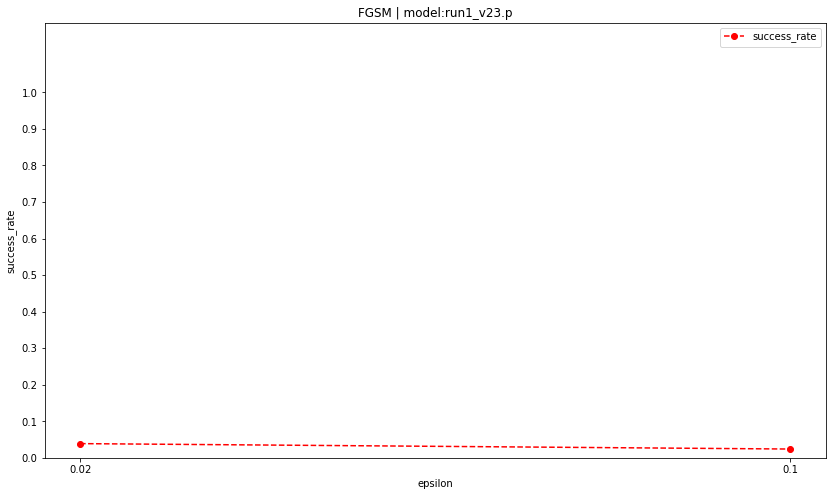

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #2/3: FGA L2


100%|██████████| 2/2 [00:06<00:00,  3.29s/it]


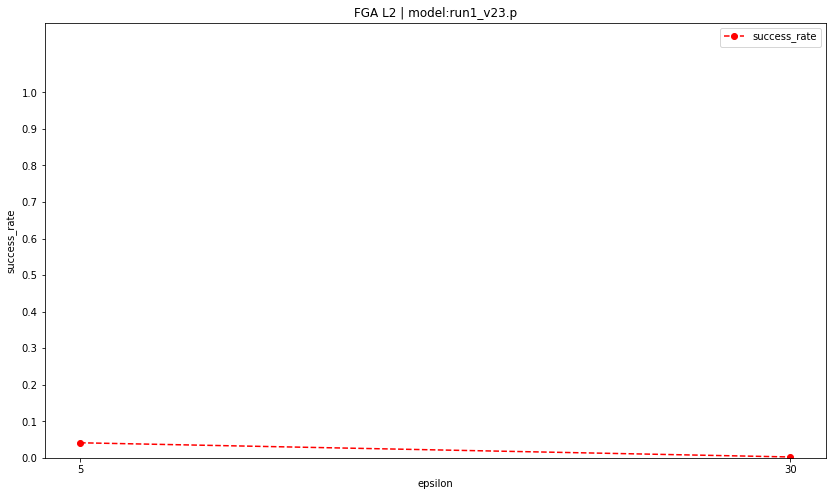

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #3/3: FGA L1


100%|██████████| 2/2 [00:06<00:00,  3.28s/it]


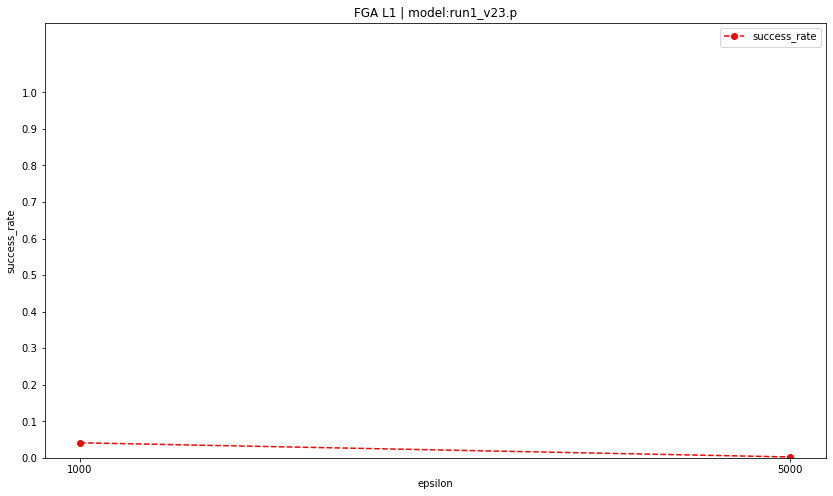

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"
Robustness-Performance:  3.037937166567872


[I 2020-06-21 16:25:39,473] Finished trial#23 with value: 3.037937166567872 with parameters: {'batch_size': 64, 'learning_rate': 0.09966469651254693, 'p_drop': 0.4463723650648035, 'lr_decay': 0.8191483494113915, 'weight_decay': 0.07241440973227077, 'eps_up': 76.77782109666668}. Best is trial#3 with value: 4.1096621221102545.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

   | Name           | Type         | Params
-------------------------------------

Val-Acc=0.03793716656787196


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.35684647302904565


Val-Acc=0.6899822169531713


Val-Acc=0.7688203912270303


Val-Acc=0.7960877296976882


Val-Acc=0.7700059276822763


Val-Acc=0.7972732661529343


Val-Acc=0.7729697688203913


Val-Acc=0.8144635447540012


Val-Acc=0.7889745109662122


Val-Acc=0.8032009484291642


Val-Acc=0.8061647895672792


Val-Acc=0.7842323651452282


Val-Acc=0.8020154119739182


Val-Acc=0.7907528156490812


Val-Acc=0.6982809721398933


Val-Acc=0.7196206283343213


Val-Acc=0.7172495554238293


Val-Acc=0.7486662714878483


Val-Acc=0.6787196206283344


Val-Acc=0.7765263781861292

Saved model to "saved_models/run1_v24.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/2 [00:00<?, ?it/s]



Running experiment on model run1_v24.p
Created Dir '/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/run1_v24.p'

Perform Attack #1/3: FGSM


100%|██████████| 2/2 [00:08<00:00,  4.34s/it]


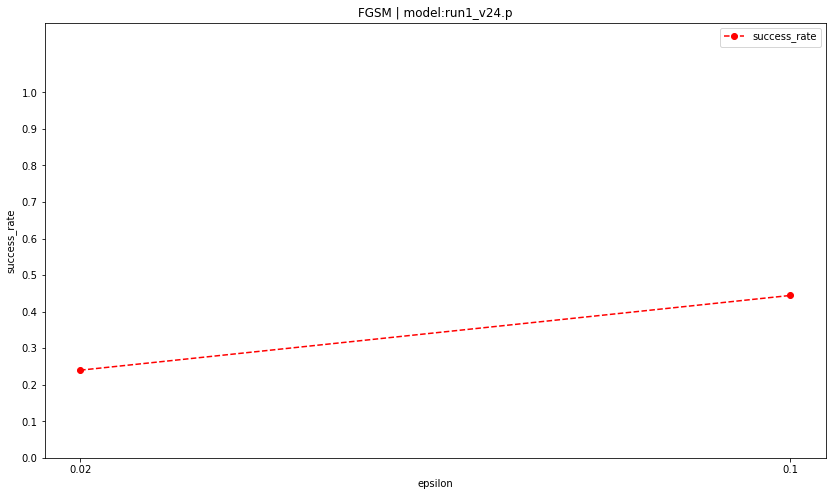

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #2/3: FGA L2


100%|██████████| 2/2 [00:08<00:00,  4.26s/it]


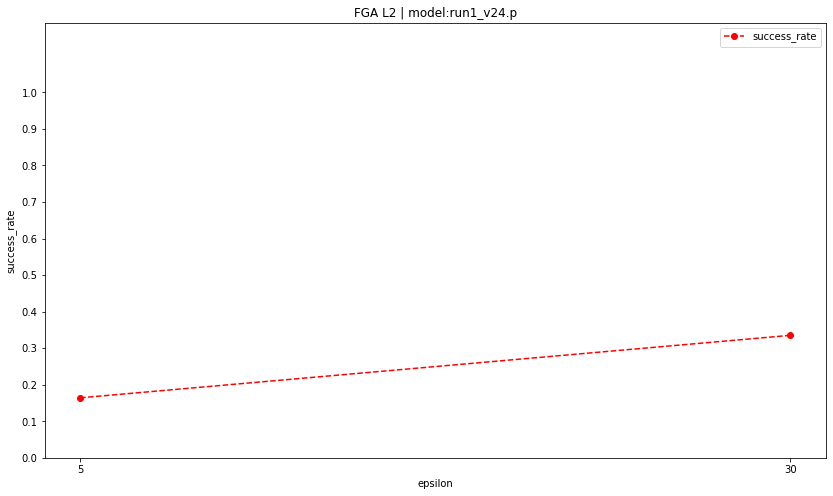

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #3/3: FGA L1


100%|██████████| 2/2 [00:08<00:00,  4.25s/it]


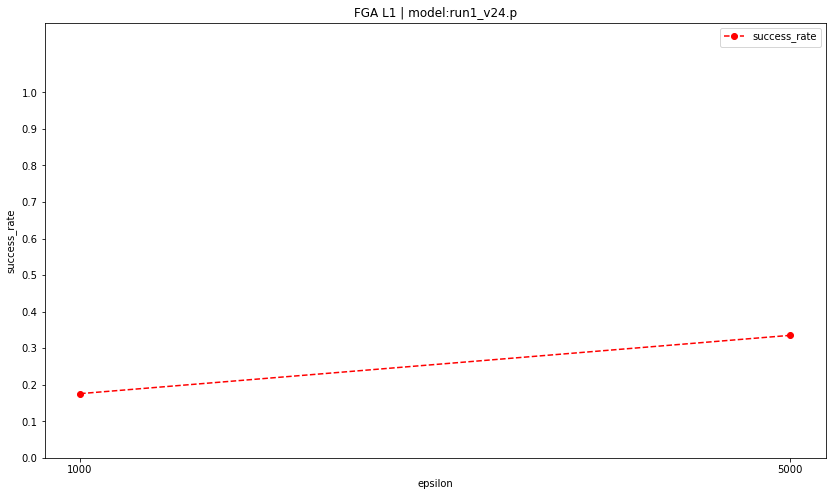

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"
Robustness-Performance:  3.3438055720213398


[I 2020-06-21 16:33:14,647] Finished trial#24 with value: 3.3438055720213398 with parameters: {'batch_size': 64, 'learning_rate': 0.009154145759396352, 'p_drop': 0.22627946072265734, 'lr_decay': 0.8360022437621867, 'weight_decay': 0.05708719854486213, 'eps_up': 46.71095304162033}. Best is trial#3 with value: 4.1096621221102545.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

   | Name           | Type         | Params
----------------------------------

Val-Acc=0.03793716656787196


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.6229994072317724


Val-Acc=0.7907528156490812


Val-Acc=0.7694131594546533


Val-Acc=0.7729697688203913


Val-Acc=0.5145228215767634


Val-Acc=0.7901600474214582


Val-Acc=0.8174273858921162


Val-Acc=0.6982809721398933


Val-Acc=0.7368109069353883


Val-Acc=0.6182572614107884


Val-Acc=0.6502667457024304


Val-Acc=0.7320687611144042


Val-Acc=0.7498518079430943


Val-Acc=0.6899822169531713


Val-Acc=0.7314759928867812


Val-Acc=0.7498518079430943


Val-Acc=0.7741553052756373


Val-Acc=0.7445168938944873


Val-Acc=0.8316538233550682


Val-Acc=0.7753408417308832

Saved model to "saved_models/run1_v25.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/2 [00:00<?, ?it/s]



Running experiment on model run1_v25.p
Created Dir '/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/run1_v25.p'

Perform Attack #1/3: FGSM


100%|██████████| 2/2 [00:08<00:00,  4.33s/it]


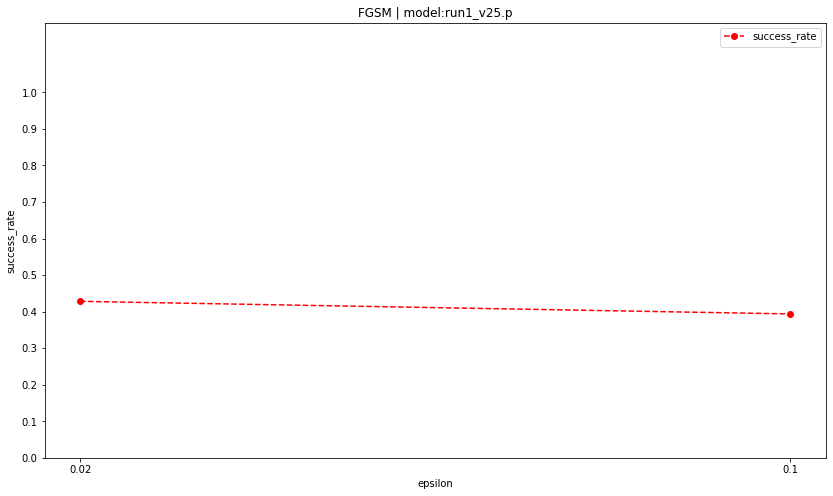

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #2/3: FGA L2


100%|██████████| 2/2 [00:08<00:00,  4.24s/it]


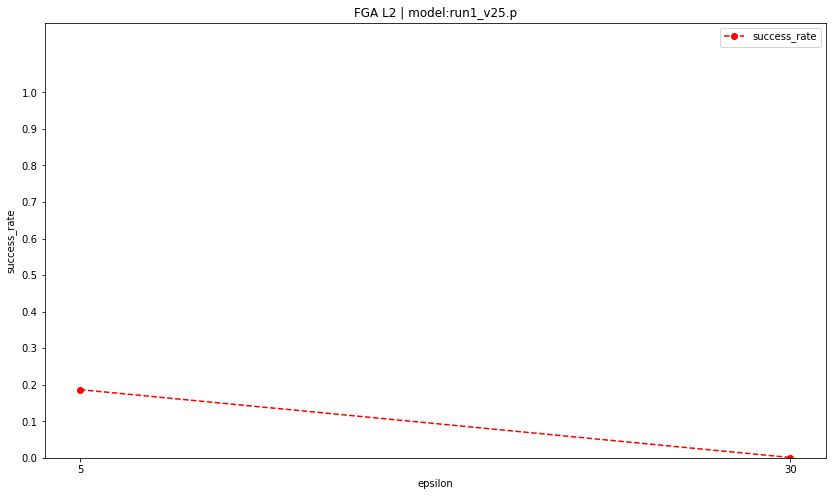

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #3/3: FGA L1


100%|██████████| 2/2 [00:08<00:00,  4.24s/it]


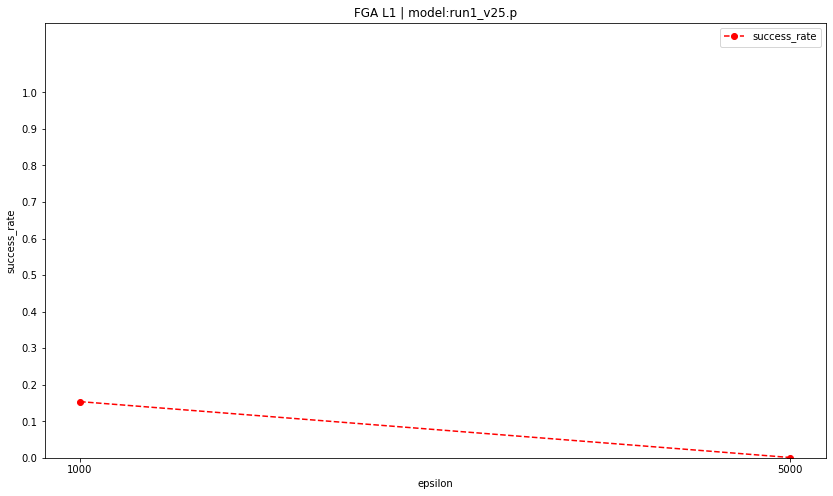

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"
Robustness-Performance:  3.7498518079430943


[I 2020-06-21 16:40:50,525] Finished trial#25 with value: 3.7498518079430943 with parameters: {'batch_size': 64, 'learning_rate': 0.03961025665947721, 'p_drop': 0.30782523608102846, 'lr_decay': 0.8257224583836202, 'weight_decay': 0.04289471964294135, 'eps_up': 109.08984457761916}. Best is trial#3 with value: 4.1096621221102545.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

   | Name           | Type         | Params
----------------------------------

Val-Acc=0.03793716656787196


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.7427385892116183


Val-Acc=0.6887966804979253


Val-Acc=0.7830468286899822


Val-Acc=0.7777119146413752


Val-Acc=0.8061647895672792


Val-Acc=0.8067575577949022


Val-Acc=0.8055720213396562


Val-Acc=0.8292827504445762


Val-Acc=0.8091286307053942


Val-Acc=0.8037937166567872


Val-Acc=0.8008298755186722


Val-Acc=0.8286899822169532


Val-Acc=0.8239478363959691


Val-Acc=0.8126852400711322


Val-Acc=0.8091286307053942


Val-Acc=0.8369887374036752


Val-Acc=0.8328393598103142


Val-Acc=0.8381742738589212


Val-Acc=0.7391819798458803


Val-Acc=0.8186129223473622

Saved model to "saved_models/run1_v26.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/2 [00:00<?, ?it/s]



Running experiment on model run1_v26.p
Created Dir '/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/run1_v26.p'

Perform Attack #1/3: FGSM


100%|██████████| 2/2 [00:09<00:00,  4.53s/it]


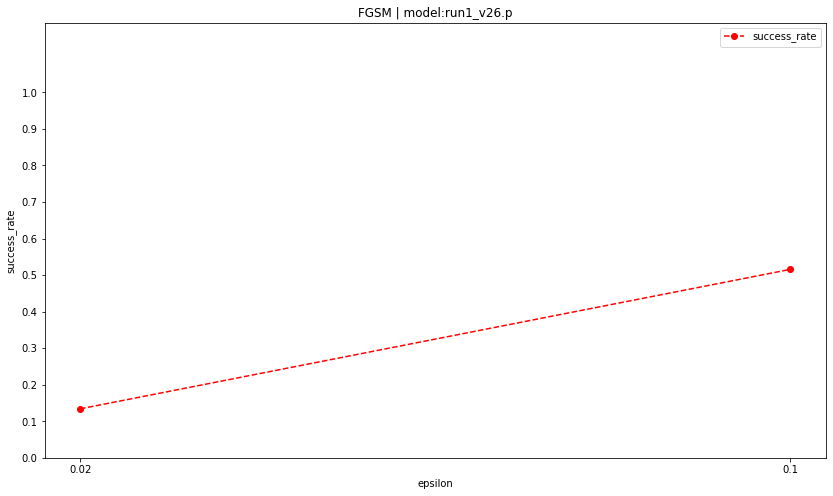

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #2/3: FGA L2


100%|██████████| 2/2 [00:08<00:00,  4.44s/it]


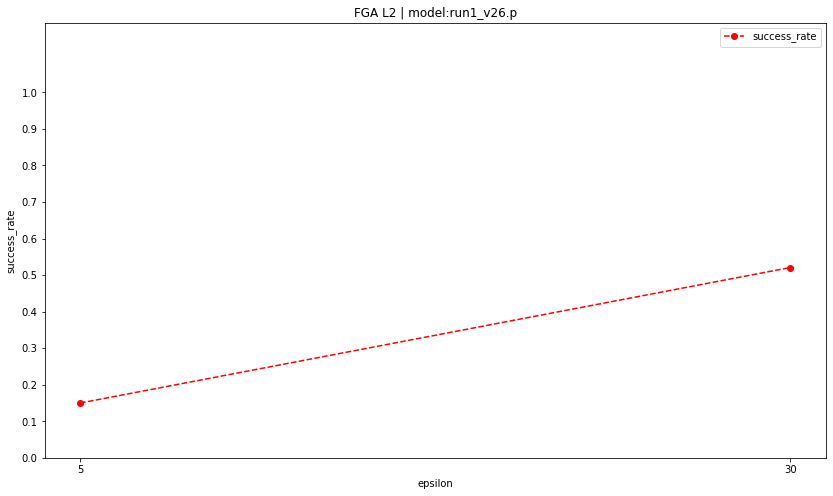

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #3/3: FGA L1


100%|██████████| 2/2 [00:08<00:00,  4.44s/it]


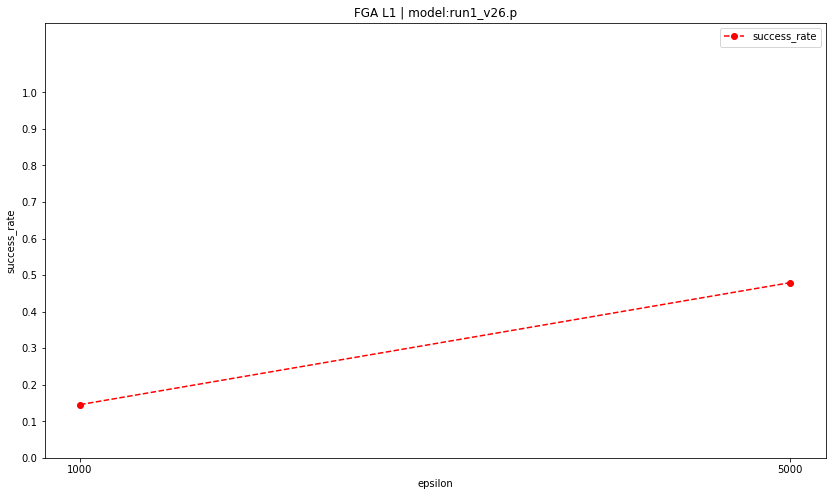

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"
Robustness-Performance:  3.319502074688797


[I 2020-06-21 16:48:28,883] Finished trial#26 with value: 3.319502074688797 with parameters: {'batch_size': 64, 'learning_rate': 0.0012018943521982996, 'p_drop': 0.30244728135783305, 'lr_decay': 0.8721518013271314, 'weight_decay': 0.03915313280799775, 'eps_up': 111.16058651869488}. Best is trial#3 with value: 4.1096621221102545.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

   | Name           | Type         | Params
---------------------------------

Val-Acc=0.03556609365737996


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.7824540604623592


Val-Acc=0.7996443390634262


Val-Acc=0.7741553052756373


Val-Acc=0.7877889745109662


Val-Acc=0.7907528156490812


Val-Acc=0.8043864848844102


Val-Acc=0.8073503260225252


Val-Acc=0.7848251333728512


Val-Acc=0.7794902193242442


Val-Acc=0.7474807350326023


Val-Acc=0.5898043864848844


Val-Acc=0.7534084173088322


Val-Acc=0.6152934202726734


Val-Acc=0.5862477771191464


Val-Acc=0.6152934202726734


Val-Acc=0.5530527563722585


Val-Acc=0.5975103734439834


Val-Acc=0.5382335506816834


Val-Acc=0.7486662714878483


Val-Acc=0.6265560165975104

Saved model to "saved_models/run1_v27.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/2 [00:00<?, ?it/s]



Running experiment on model run1_v27.p
Created Dir '/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/run1_v27.p'

Perform Attack #1/3: FGSM


100%|██████████| 2/2 [00:07<00:00,  3.79s/it]


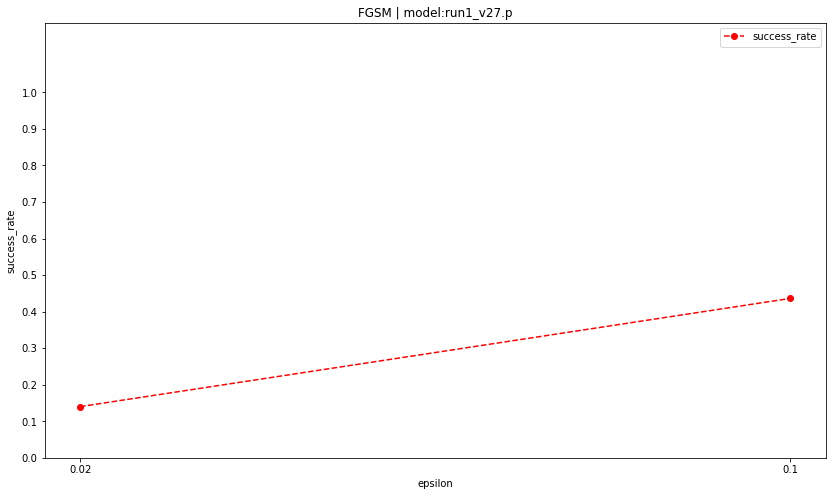

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #2/3: FGA L2


100%|██████████| 2/2 [00:07<00:00,  3.67s/it]


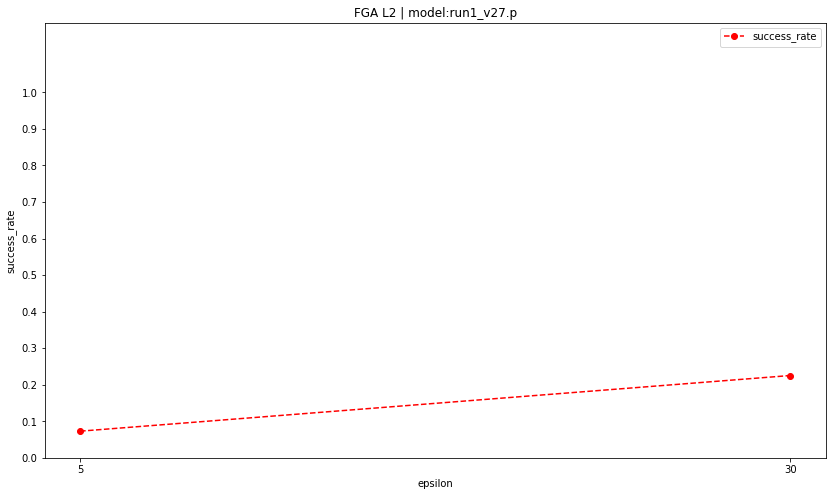

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #3/3: FGA L1


100%|██████████| 2/2 [00:07<00:00,  3.67s/it]


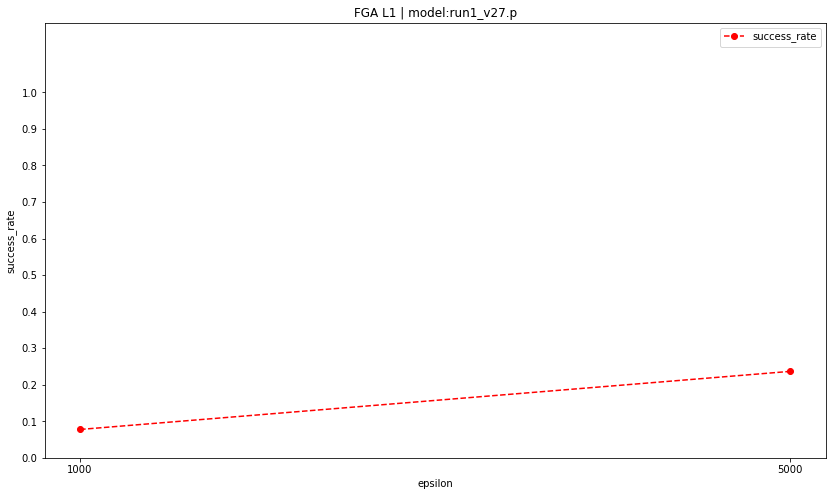

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"
Robustness-Performance:  3.014819205690575


[I 2020-06-21 16:56:06,455] Finished trial#27 with value: 3.014819205690575 with parameters: {'batch_size': 64, 'learning_rate': 0.004317693356591133, 'p_drop': 0.3573480909539544, 'lr_decay': 0.9263518919989324, 'weight_decay': 0.029257654549921165, 'eps_up': 35.631419476035184}. Best is trial#3 with value: 4.1096621221102545.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

   | Name           | Type         | Params
----------------------------------

Val-Acc=0.03793716656787196


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.6490812092471844


Val-Acc=0.6917605216360403


Val-Acc=0.6876111440426793


Val-Acc=0.7131001778304683


Val-Acc=0.6544161232957914


Val-Acc=0.6295198577356254


Val-Acc=0.5826911677534085


Val-Acc=0.6461173681090694


Val-Acc=0.6532305868405454


Val-Acc=0.6467101363366924


Val-Acc=0.6526378186129224


Val-Acc=0.6538233550681684


Val-Acc=0.6662714878482513


Val-Acc=0.6502667457024304


Val-Acc=0.6591582691167753


Val-Acc=0.6532305868405454


Val-Acc=0.6639004149377593


Val-Acc=0.6390041493775933


Val-Acc=0.6473029045643154


Val-Acc=0.6621221102548903

Saved model to "saved_models/run1_v28.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/2 [00:00<?, ?it/s]



Running experiment on model run1_v28.p
Created Dir '/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/run1_v28.p'

Perform Attack #1/3: FGSM


100%|██████████| 2/2 [00:07<00:00,  3.89s/it]


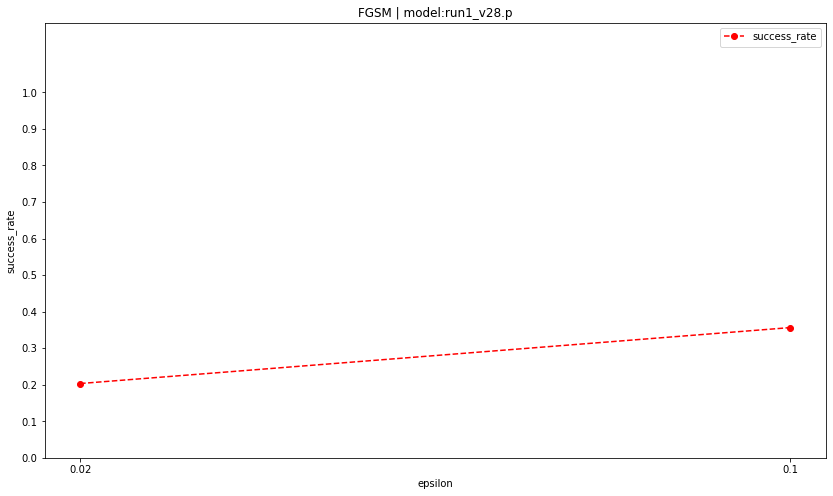

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #2/3: FGA L2


100%|██████████| 2/2 [00:07<00:00,  3.81s/it]


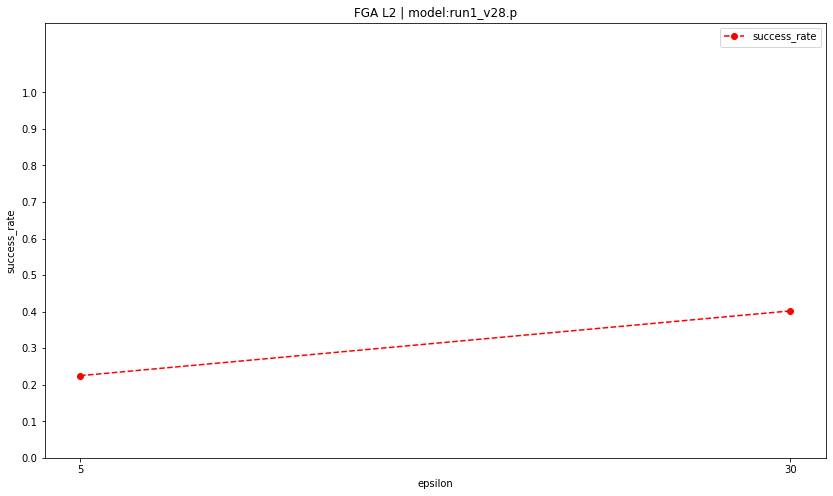

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #3/3: FGA L1


100%|██████████| 2/2 [00:07<00:00,  3.81s/it]


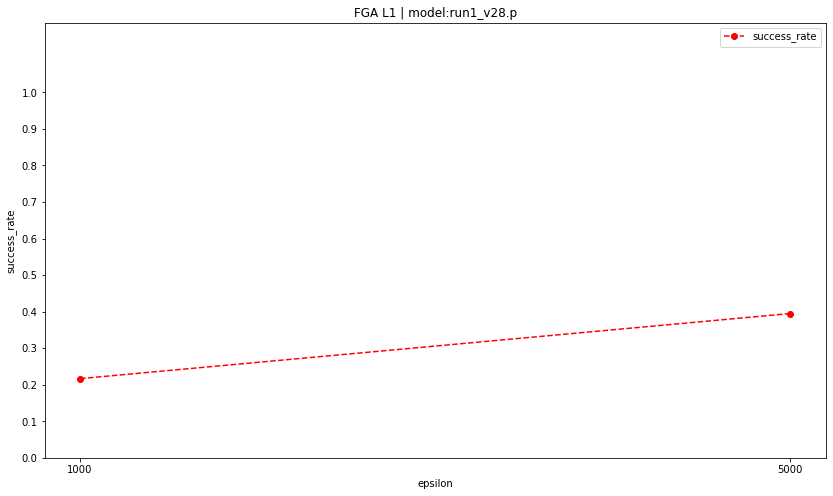

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"
Robustness-Performance:  2.782454060462359


[I 2020-06-21 17:04:01,872] Finished trial#28 with value: 2.782454060462359 with parameters: {'batch_size': 64, 'learning_rate': 0.00014161042943924265, 'p_drop': 0.24648439023149046, 'lr_decay': 0.8110863350515436, 'weight_decay': 0.0454081944508679, 'eps_up': 10.106995332925553}. Best is trial#3 with value: 4.1096621221102545.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

   | Name           | Type         | Params
---------------------------------

Val-Acc=0.03793716656787196


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.5121517486662714


Val-Acc=0.6876111440426793


Val-Acc=0.7036158861885004


Val-Acc=0.5257854179016005


Val-Acc=0.6265560165975104


Val-Acc=0.7048014226437463


Val-Acc=0.6988737403675163


Val-Acc=0.7445168938944873


Val-Acc=0.7581505631298162


Val-Acc=0.6247777119146414


Val-Acc=0.7996443390634262


Val-Acc=0.7510373443983402


Val-Acc=0.7830468286899822


Val-Acc=0.6004742145820984


Val-Acc=0.8049792531120332


Val-Acc=0.6870183758150563


Val-Acc=0.6976882039122703


Val-Acc=0.8192056905749852


Val-Acc=0.7350326022525193


Val-Acc=0.7136929460580913

Saved model to "saved_models/run1_v29.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/2 [00:00<?, ?it/s]



Running experiment on model run1_v29.p
Created Dir '/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/run1_v29.p'

Perform Attack #1/3: FGSM


100%|██████████| 2/2 [00:08<00:00,  4.06s/it]


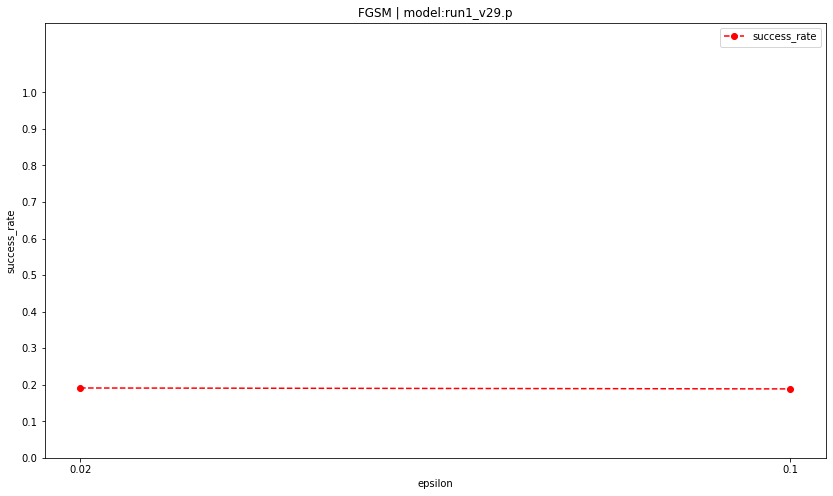

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #2/3: FGA L2


100%|██████████| 2/2 [00:07<00:00,  3.98s/it]


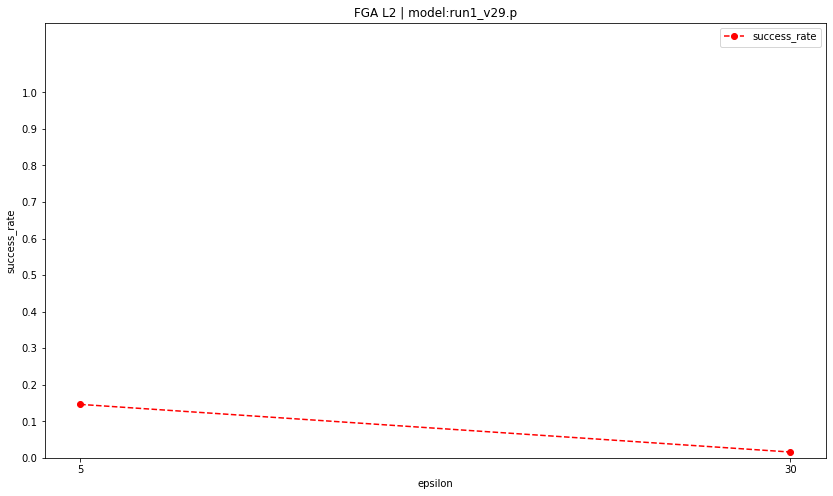

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #3/3: FGA L1


100%|██████████| 2/2 [00:07<00:00,  3.98s/it]


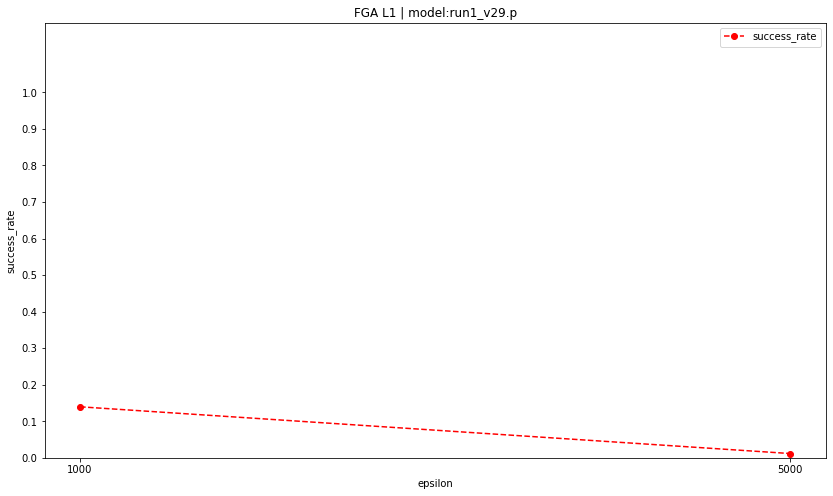

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"
Robustness-Performance:  3.787788974510966


[I 2020-06-21 17:11:51,503] Finished trial#29 with value: 3.787788974510966 with parameters: {'batch_size': 64, 'learning_rate': 0.06560395498637918, 'p_drop': 0.2996893226697731, 'lr_decay': 0.8613941825373705, 'weight_decay': 0.055330143177081605, 'eps_up': 109.82005260876686}. Best is trial#3 with value: 4.1096621221102545.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

   | Name           | Type         | Params
-----------------------------------

Val-Acc=0.03793716656787196


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.7978660343805573


Val-Acc=0.7202133965619443


Val-Acc=0.5743924125666864


Val-Acc=0.6520450503852994


Val-Acc=0.5951393005334914


Val-Acc=0.7409602845287493


Val-Acc=0.6858328393598103


Val-Acc=0.6982809721398933


Val-Acc=0.7255483106105513


Val-Acc=0.7462951985773563


Val-Acc=0.6953171310017783


Val-Acc=0.6982809721398933


Val-Acc=0.7030231179608772


Val-Acc=0.7830468286899822


Val-Acc=0.8174273858921162


Val-Acc=0.7771191464137522


Val-Acc=0.7427385892116183


Val-Acc=0.8138707765263782


Val-Acc=0.7291049199762892


Val-Acc=0.7374036751630113

Saved model to "saved_models/run1_v30.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/2 [00:00<?, ?it/s]



Running experiment on model run1_v30.p
Created Dir '/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/run1_v30.p'

Perform Attack #1/3: FGSM


100%|██████████| 2/2 [00:08<00:00,  4.21s/it]


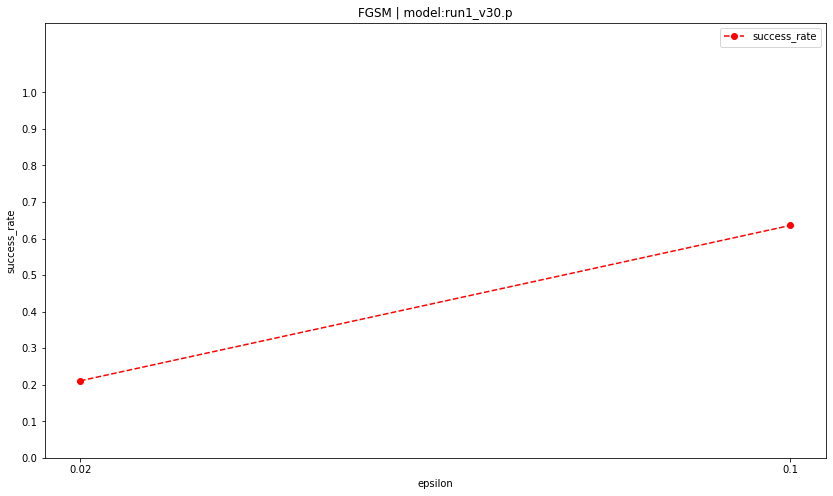

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #2/3: FGA L2


100%|██████████| 2/2 [00:08<00:00,  4.06s/it]


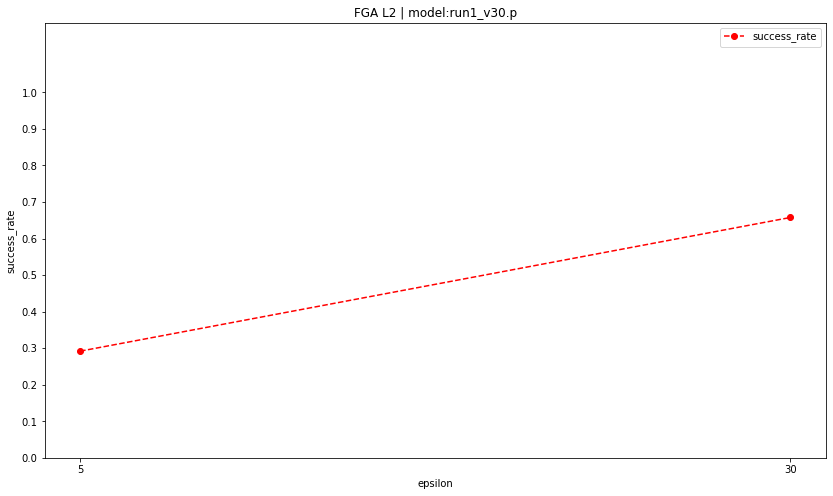

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #3/3: FGA L1


100%|██████████| 2/2 [00:08<00:00,  4.06s/it]


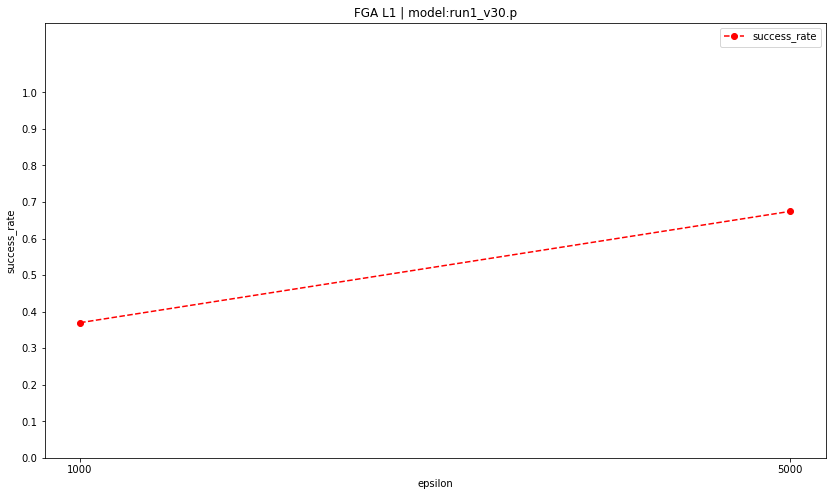

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"
Robustness-Performance:  2.330171902786011


[I 2020-06-21 17:19:17,921] Finished trial#30 with value: 2.330171902786011 with parameters: {'batch_size': 64, 'learning_rate': 0.08298475594014412, 'p_drop': 0.3725357597954274, 'lr_decay': 0.8818481754589373, 'weight_decay': 0.056123073481844116, 'eps_up': 1.7363221651236282}. Best is trial#3 with value: 4.1096621221102545.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

   | Name           | Type         | Params
-----------------------------------

Val-Acc=0.03793716656787196


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.5696502667457024


Val-Acc=0.5050385299347955


Val-Acc=0.7142857142857143


Val-Acc=0.7261410788381742


Val-Acc=0.5572021339656195


Val-Acc=0.5856550088915234


Val-Acc=0.7540011855364552


Val-Acc=0.6799051570835803


Val-Acc=0.7071724955542383


Val-Acc=0.7919383521043272


Val-Acc=0.6662714878482513


Val-Acc=0.7131001778304683


Val-Acc=0.7747480735032602


Val-Acc=0.8275044457617071


Val-Acc=0.7901600474214582


Val-Acc=0.8109069353882632


Val-Acc=0.8316538233550682


Val-Acc=0.7895672791938352


Val-Acc=0.7949021932424422


Val-Acc=0.8346176644931832

Saved model to "saved_models/run1_v31.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/2 [00:00<?, ?it/s]



Running experiment on model run1_v31.p
Created Dir '/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/run1_v31.p'

Perform Attack #1/3: FGSM


100%|██████████| 2/2 [00:23<00:00, 11.63s/it]


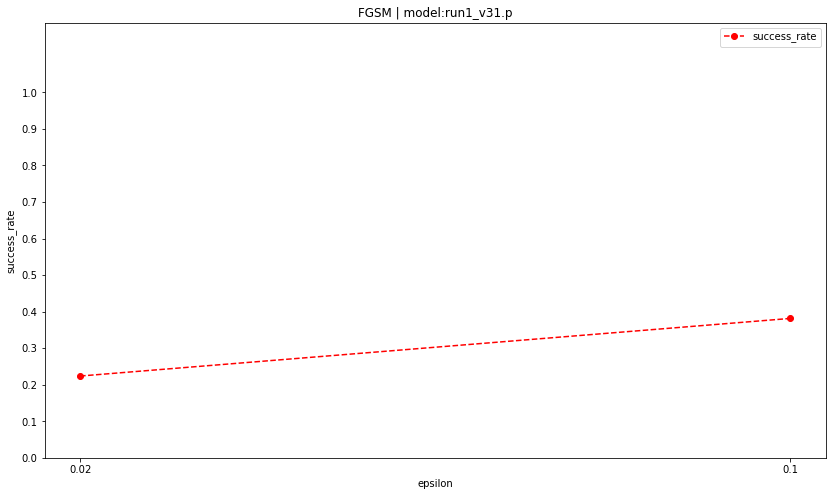

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #2/3: FGA L2


100%|██████████| 2/2 [00:17<00:00,  8.61s/it]


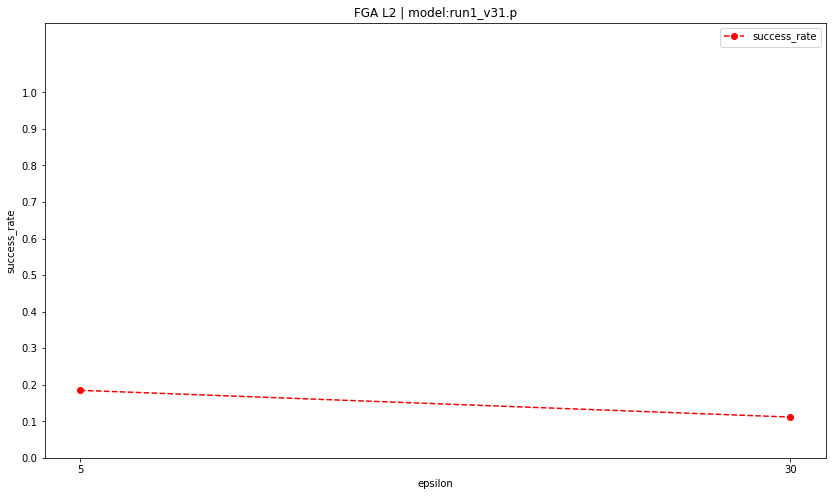

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #3/3: FGA L1


100%|██████████| 2/2 [00:18<00:00,  9.08s/it]


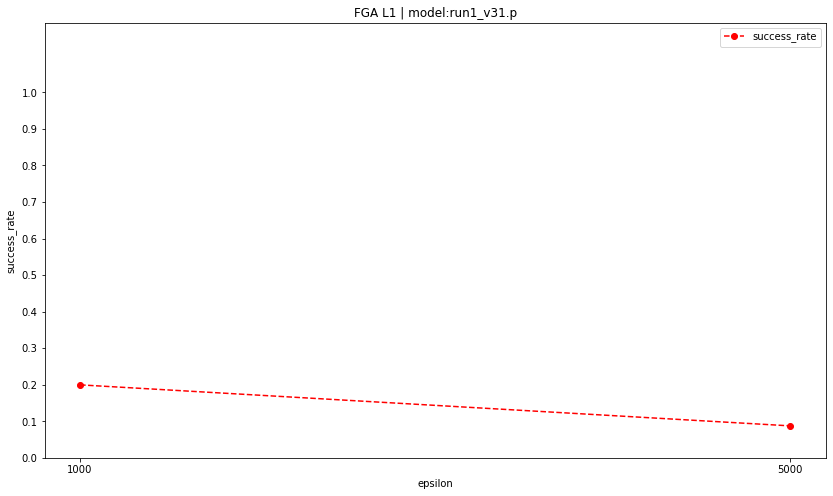

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"
Robustness-Performance:  4.016004742145821


[I 2020-06-21 17:29:23,431] Finished trial#31 with value: 4.016004742145821 with parameters: {'batch_size': 64, 'learning_rate': 0.05582078534345022, 'p_drop': 0.30297410656830237, 'lr_decay': 0.8572490882171148, 'weight_decay': 0.05160163931039848, 'eps_up': 100.5571507413009}. Best is trial#3 with value: 4.1096621221102545.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

   | Name           | Type         | Params
------------------------------------

Val-Acc=0.03793716656787196


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.5097806757557795


Val-Acc=0.7261410788381742


Val-Acc=0.6123295791345584


Val-Acc=0.7498518079430943


Val-Acc=0.7842323651452282


Val-Acc=0.6810906935388263


Val-Acc=0.7213989330171903


Val-Acc=0.7824540604623592


Val-Acc=0.5637225844694724


Val-Acc=0.7107291049199763


Val-Acc=0.8156490812092472


Val-Acc=0.6235921754593954


Val-Acc=0.7943094250148192


Val-Acc=0.7551867219917012


Val-Acc=0.7534084173088322


Val-Acc=0.7522228808535862


Val-Acc=0.8275044457617071


Val-Acc=0.7634854771784232


Val-Acc=0.8026081802015412


Val-Acc=0.8114997036158862

Saved model to "saved_models/run1_v32.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/2 [00:00<?, ?it/s]



Running experiment on model run1_v32.p
Created Dir '/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/run1_v32.p'

Perform Attack #1/3: FGSM


100%|██████████| 2/2 [00:20<00:00, 10.41s/it]


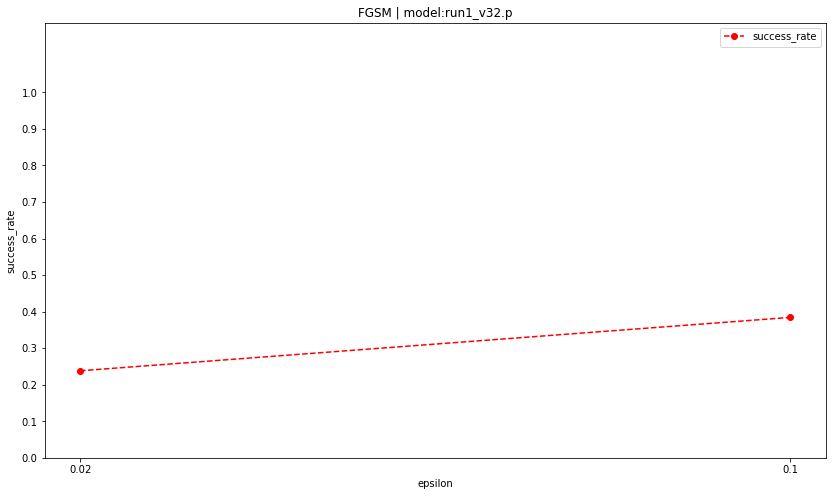

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #2/3: FGA L2


100%|██████████| 2/2 [00:19<00:00,  9.76s/it]


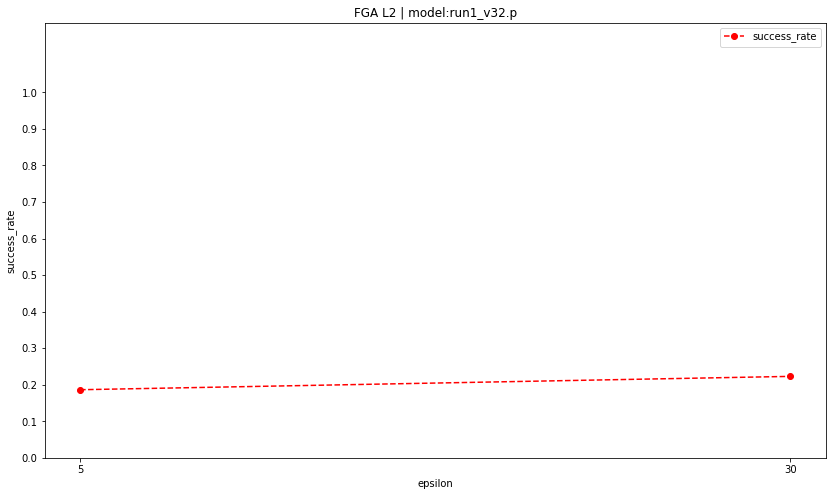

  0%|          | 0/2 [00:00<?, ?it/s]

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"

Perform Attack #3/3: FGA L1


100%|██████████| 2/2 [00:18<00:00,  9.23s/it]


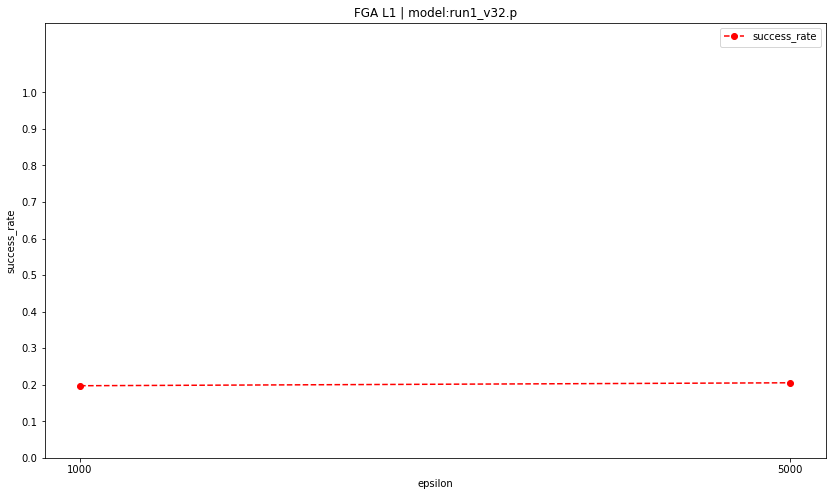

Backup created at "/nfs/students/summer-term-2020/project-4/EXPERIMENTS/0007_QUICK_EVALUATION/backup.pickle"
Robustness-Performance:  3.7053941908713695


[I 2020-06-21 17:41:28,796] Finished trial#32 with value: 3.7053941908713695 with parameters: {'batch_size': 64, 'learning_rate': 0.05853002226491523, 'p_drop': 0.22594569311786408, 'lr_decay': 0.8634358398888383, 'weight_decay': 0.05118769148863612, 'eps_up': 146.63680128718784}. Best is trial#3 with value: 4.1096621221102545.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

   | Name           | Type         | Params
----------------------------------

Val-Acc=0.03793716656787196


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.6022525192649674


Val-Acc=0.7901600474214582


Val-Acc=0.7741553052756373


Val-Acc=0.8043864848844102


Val-Acc=0.7409602845287493


Val-Acc=0.7717842323651453


Val-Acc=0.8180201541197392


Val-Acc=0.7415530527563723


Val-Acc=0.8310610551274452


Val-Acc=0.7682276229994073


Val-Acc=0.7990515708358032


Val-Acc=0.8162418494368702


Val-Acc=0.6828689982216953


Val-Acc=0.7480735032602253


Val-Acc=0.8363959691760522


Val-Acc=0.8435091879075282


In [ ]:
pruner = optuna.pruners.MedianPruner()
study = optuna.create_study(direction="maximize", pruner=None)
study.optimize(objective, n_trials=10000, timeout=21600) #6h

print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
best_trial = study.best_trial
print("  Value: {}".format(best_trial.value))
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
from utils.RobustnessExperiment import load_module
load_module("saved_models/0.p", M5PLModule)

# Evaluate Robustness

In [ ]:
##############################################################################################################
##############################################################################################################
##############################################################################################################

from utils.RobustnessExperiment import RobustnessExperiment, load_experiment
from attacks.FGA_Batch import fast_gradient_attack
from attacks.pgd import ProjectedGradientDescent
from classification.models.M5 import M5PLModule

exp_config = [{
              "attack_fn": ProjectedGradientDescent, 
              "attack_arg": {"norm":["inf"], "epsilon": [0.02, 0.1]},
              "meta": {"key_result":"success_rate", "key_config":"epsilon", "title":"FGSM"}
             },
            {
            "attack_fn": ProjectedGradientDescent, 
            "attack_arg": {"norm":["2"], "epsilon": [5, 30]},
            "meta": {"key_result":"success_rate", "key_config":"epsilon", "title":"FGA L2"}
            },
            {
            "attack_fn": ProjectedGradientDescent, 
            "attack_arg": {"norm":["1"], "epsilon": [1000, 5000]},
            "meta": {"key_result":"success_rate", "key_config":"epsilon", "title":"FGA L1"}
            }]

# uncomment this if you want to create a new experiment instead!
#experiment = RobustnessExperiment(exp_config, title="QUICK_EVALUATION")
experiment = load_experiment(exp_folder = "0007_QUICK_EVALUATION")

#experiment.run("./1592000682.p", M5PLModule) #20 epochs normal training with hparams above
experiment.run("/nfs/students/summer-term-2020/project-4/SAVED_MODELS/M5/M5_attack_ProjectedGradientDescent_v8_epoch_25.p", M5PLModule) #5 epochs adv training with hparams above

models = ['/nfs/students/summer-term-2020/project-4/SAVED_MODELS/M5/M5_attack_ProjectedGradientDescent_v69_epoch_10.p',
          '/nfs/students/summer-term-2020/project-4/SAVED_MODELS/M5/M5_attack_ProjectedGradientDescent_v69_epoch_20.p',
          '/nfs/students/summer-term-2020/project-4/SAVED_MODELS/M5/M5_attack_ProjectedGradientDescent_v69_epoch_30.p',
          '/nfs/students/summer-term-2020/project-4/SAVED_MODELS/M5/M5_attack_ProjectedGradientDescent_v69_epoch_40.p',]

for m in models:
    experiment.run(m, M5PLModule)
##############################################################################################################
##############################################################################################################
##############################################################################################################

In [ ]:
experiment.all_results

robustness_acc_sum = 0
for attack in experiment.all_results.keys():
    print(experiment.all_results[attack]["M5_attack_ProjectedGradientDescent_v8_epoch_25.p"])
    
model_name = "M5_attack_ProjectedGradientDescent_v8_epoch_25.p"
reports_per_attack = [ experiment.all_results[atk][model_name] for atk in experiment.all_results.keys()] 

print(reports_per_attack)

In [ ]:
experiment.show_evaluated_models()

In [ ]:
model_name = "M5_attack_ProjectedGradientDescent_v8_epoch_25.p"
experiment.get_model_performance(model_name)